# Co-56 run 3882

#### Trigger on S2, Qmin ~1500 keV

In [50]:
from __future__ import print_function, division
%load_ext autoreload
%autoreload 2
import os
import operator
import functools
import textwrap
import copy
import time
import glob
import math
print("Running on ", time.asctime())

import textwrap
import numpy as np
import pandas as pd
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

import invisible_cities.database.load_db as DB
import invisible_cities.core.system_of_units_c as SystemOfUnits
import invisible_cities.reco.pmaps_functions as pmapf
import invisible_cities.core.fit_functions as fitf

import invisible_cities.core.core_functions as cf

from invisible_cities.core.core_functions import timefunc, flat
from invisible_cities.reco.pmaps_functions import width, integrate_charge
from icaro.core.hst_functions import labels, hist, doublehist, hist2d, pdf, scatter, profile_and_scatter,\
                              doublescatter, covariance, reso, gausstext, plot_profile_histogram 

from scipy.optimize import curve_fit
from icaro.core.kdst_functions import load_dst, event_rate, profile_and_fit, \
                               profile_and_fit_radial, print_fit, MapXY, chi2, \
                               time_from_timestamp, lifetime, time_vector_from_timestamp_vector
DataPMT = DB.DataPMT()
DataSiPM = DB.DataSiPM()
units = SystemOfUnits.SystemOfUnits()
pi = np.pi


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Running on  Thu May  4 19:25:31 2017


In [4]:
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2017-05-04 18:53:33


#### General plotting options

In [39]:
def plot_options(figsize=(6,6), fontsize=8):
    plt.rcParams["figure.figsize"]          = figsize
    plt.rcParams["font.size"]               = fontsize
    plt.rcParams["figure.max_open_warning"] = 100

In [6]:
plt.rcParams["figure.figsize"]          = 6, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

outputfolder = "plots/"
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

#### Useful functions

### Run

In [7]:
run_number = 3882

### Input data

In [10]:
# Comment out this line if your data is in $IC_DATA
#ifile = os.path.expandvars("/Users/Gonzalo/github/NEXTdata/Na22/Na22DST.h5")
ifile = os.path.join(os.environ['IC_DATA'],
                        'LSC/kdst/{}/kdst_{}.h5'.format(run_number, run_number))
print("ifile:", ifile)

ifile: /Users/jjgomezcadenas/Projects/ICDATA/LSC/kdst/3882/kdst_3882.h5


# Read data

In [11]:
full = load_dst(ifile)
print(len(full))
full.head()

3298


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,4,1.493853e+09,0,1,150.0,69.900978,339.020317,645200.0,51.833000,26345.716797,...,663462.5,112,18.2625,18.2625,-26.122175,-112.195866,115.196703,-1.799548,23.578372,39.519335
1,6,1.493853e+09,0,1,325.0,80.897087,462.510270,470400.0,60.778750,15068.369141,...,677887.5,71,207.4875,207.4875,-77.840109,76.611606,109.217309,2.364148,22.573705,21.451431
2,7,1.493853e+09,0,2,250.0,42.498703,239.012693,546175.0,27.727250,18398.777344,...,668512.5,55,122.3375,122.3375,-9.818639,59.454752,60.260046,1.734464,15.306511,20.940061
3,7,1.493853e+09,1,2,250.0,42.498703,239.012693,546175.0,9.630625,1585.407471,...,695787.5,2,149.6125,149.6125,-5.000000,80.366040,80.521428,1.632932,0.000000,5.021243
4,13,1.493853e+09,0,1,300.0,65.800499,389.518567,538600.0,47.183375,20906.158203,...,667837.5,79,129.2375,129.2375,68.583645,-61.952512,92.422021,-0.734643,16.782022,20.864640


### Trigger rate and z distribution 

In [12]:
r = event_rate(full)

In [13]:
print("Trigger rate: {} evts/s".format(r))

Trigger rate: 0.1126817770950432 evts/s


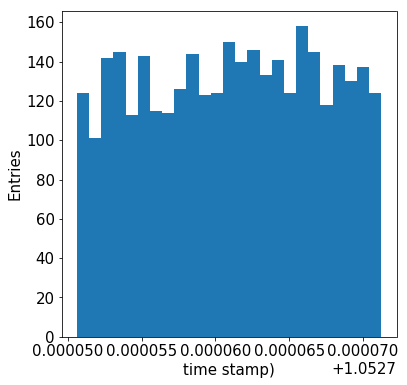

In [14]:
hist(full.time/1.419e+9, 25)
labels("time stamp)", "Entries")

In [15]:
st = [datetime.datetime.fromtimestamp(elem).strftime('%Y-%m-%d %H:%M:%S') for elem in full.time]
x = [datetime.datetime.strptime(elem, '%Y-%m-%d %H:%M:%S') for elem in st]

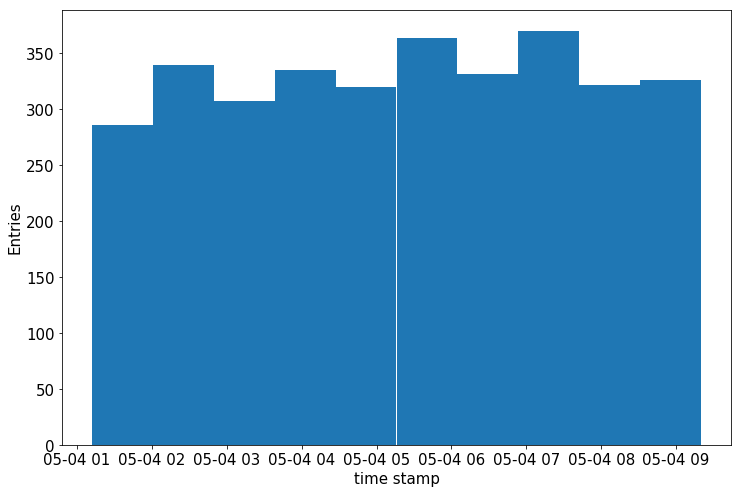

In [16]:
figsize=(12,8)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 1, 1)
nx, bx, _ = plt.hist(time_vector_from_timestamp_vector(full.time), 10)
labels("time stamp", "Entries")

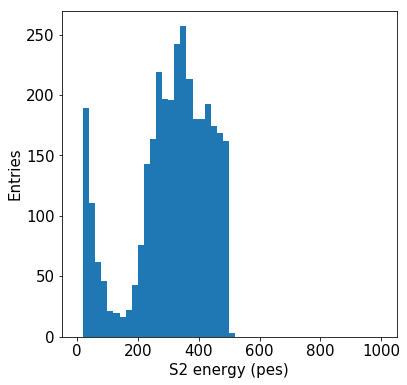

In [23]:
hist(full.S1e, 50, (0e3,1000))
labels("S2 energy (pes)", "Entries")

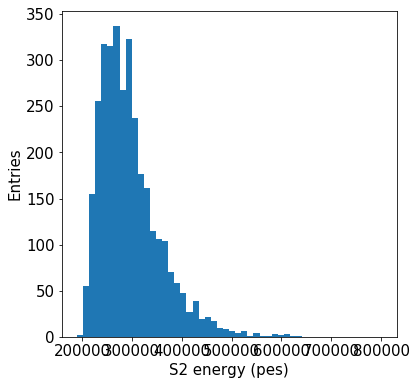

In [26]:
hist(full.S2e, 50, (190e3,800e+3))
labels("S2 energy (pes)", "Entries")

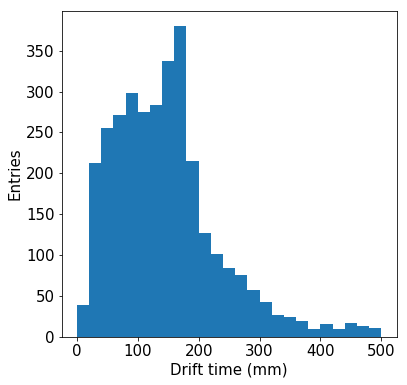

In [27]:
hist(full.Z, 25, (0,500))
labels("Drift time (mm)", "Entries")

#### Select PE enriched interactions by requiring 2 S2s 
1. PE interactions produce 80% of the time an X-ray
2. Electrons produced by Compton interactions will also produce an X-ray.
3. X rays from PE will tend to be at the interaction vertex, while X rays from Compton are produced along the electron trajectory. 

In [28]:
s2eq2 = full[full.nS2 ==2]
print("Length of data set = {}".format(len(s2eq2)))
print("RatioΩ:", len(s2eq2)/len(full))
s2eq2.head()

Length of data set = 26
RatioΩ: 0.007883565797453002


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
2,7,1.493853e+09,0,2,250.0,42.498703,239.012693,546175.0,27.727250,18398.777344,...,668512.5,55,122.3375,122.3375,-9.818639,59.454752,60.260046,1.734464,15.306511,20.940061
3,7,1.493853e+09,1,2,250.0,42.498703,239.012693,546175.0,9.630625,1585.407471,...,695787.5,2,149.6125,149.6125,-5.000000,80.366040,80.521428,1.632932,0.000000,5.021243
90,194,1.493854e+09,0,2,275.0,45.866505,264.745988,601400.0,28.130562,19586.556641,...,654437.5,64,53.0375,53.0375,111.822308,-2.699655,111.854891,-0.024138,17.907979,16.601683
91,194,1.493854e+09,1,2,275.0,45.866505,264.745988,601400.0,6.480188,2420.968506,...,692587.5,3,91.1875,91.1875,150.736457,16.612393,151.649105,0.109765,4.958111,3.686919
1190,2692,1.493864e+09,0,2,275.0,68.781143,403.562649,591100.0,49.325313,30868.867188,...,670612.5,72,79.5125,79.5125,83.593457,-87.917398,121.315023,-0.810604,43.550098,15.238197


In [29]:
PE = full

#### Z distribution

In [49]:
def histos(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist(*args, **kwargs)


In [30]:
peak_name = ['Krypton', 'Na-22-XR', 'Na-22-511', 'Na-22-1275', 'Na-22-Compton']
peak_energy = {'Krypton':41.5, 'Na-22-XR':30, 'Na-22-511':511,'Na-22-1275':1275, 'Na-22-Compton':150}
KrE = 7400
for peak in peak_name:
    print('for peak name = {} with energy {} keV, expect {} PES'.format(
    peak, peak_energy[peak], KrE * (peak_energy[peak]/peak_energy['Krypton']) ))

for peak name = Krypton with energy 41.5 keV, expect 7400.0 PES
for peak name = Na-22-XR with energy 30 keV, expect 5349.3975903614455 PES
for peak name = Na-22-511 with energy 511 keV, expect 91118.07228915663 PES
for peak name = Na-22-1275 with energy 1275 keV, expect 227349.39759036142 PES
for peak name = Na-22-Compton with energy 150 keV, expect 26746.98795180723 PES


#### S1 to S2:

#### E-Z correlation

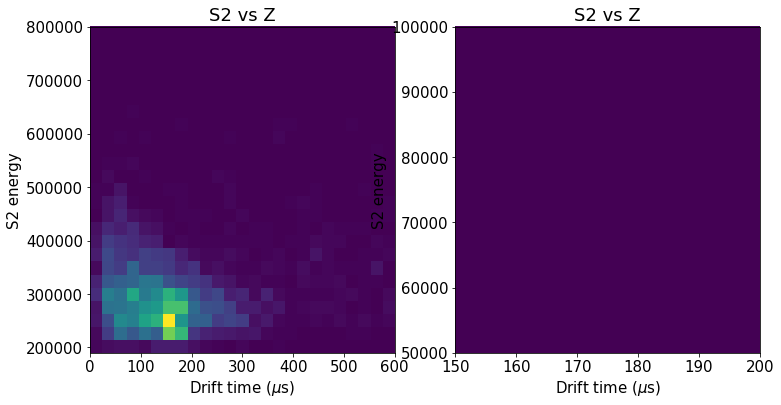

In [32]:
zrange =   0, 600
Erange = 190e3, 800e3

figsize=(12,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 2, 1)
plt.hist2d(PE.Z, PE.S2e, (25, 25), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")
plt.title('S2 vs Z')

zrange =   150, 200
Erange = 5e4, 1e5

ax = plt.subplot(1, 2, 2)
plt.hist2d(PE.Z, PE.S2e, (25, 25), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")
plt.title('S2 vs Z')



In [47]:
1275/511

2.4951076320939336

#### S1

#### S1 S2 correlation

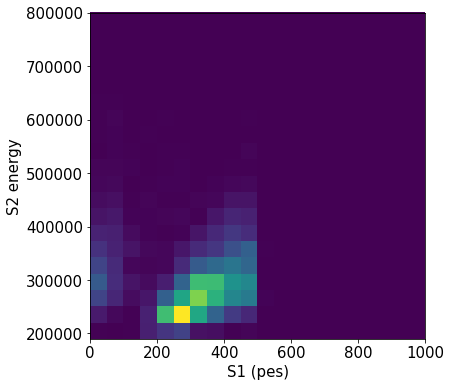

In [33]:
S1range =   0, 1000
Erange = 190e3, 800e3
hist2d(PE.S1e, PE.S2e, (20, 20), range=(S1range, Erange))
labels("S1 (pes)", "S2 energy")



#### The two regions of high density in the correlation plot above correspond to PE peak and Compton shoulder (which is cutoff by the trigger)

####  Gamma of 1275?

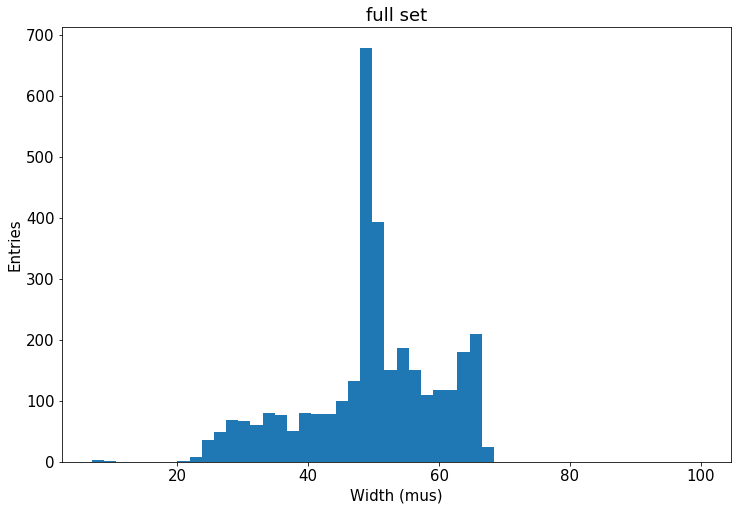

In [34]:
figsize=(12,8)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 1, 1)
plt.hist(full.S2w, 50, (7,100))
labels("Width (mus)", "Entries")
plt.title('full set')

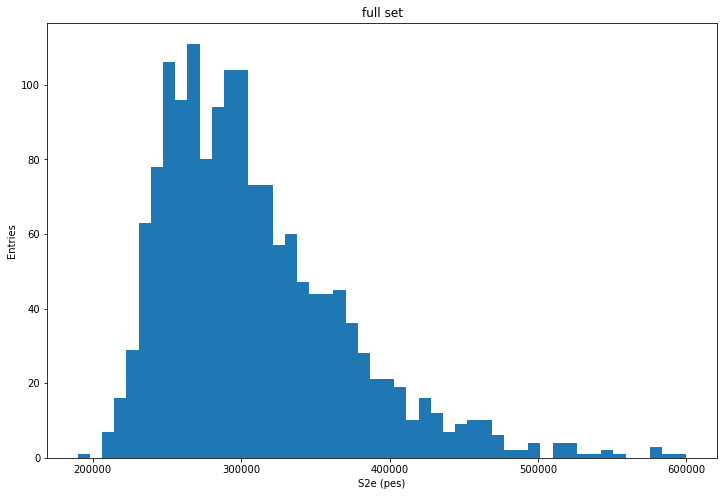

In [51]:
figsize=(12,8)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 1, 1)
plt.hist(full.S2e[cf.in_range(full.S2w,45,55)], 50, (190e+3,600e+3))
labels("S2e (pes)", "Entries")
plt.title('full set')

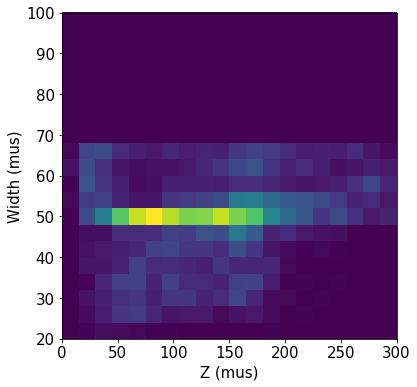

In [48]:
Wrange =   20, 100
zrange = 0, 300
hist2d(PE.Z, PE.S2w, (20, 20), range=(zrange, Wrange))
labels("Z (mus)", "Width (mus)")

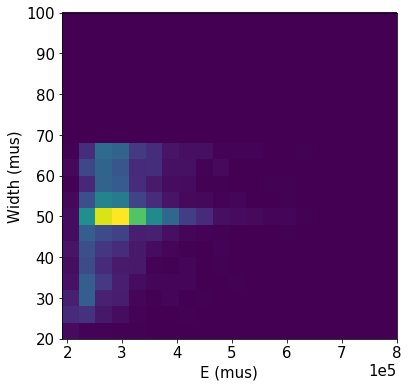

In [46]:
Erange =   190e+3, 800e+3
Wrange = 20, 100
hist2d(PE.S2e, PE.S2w, (20, 20), range=(Erange, Wrange))
#plt.tick_params(labelsize=10)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
labels("E (mus)", "Width (mus)")

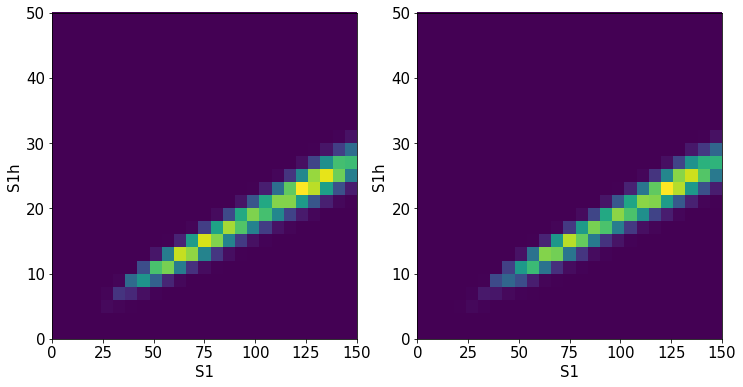

In [856]:
S1r =   0, 150
S1h = 0, 50

figsize=(12,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 2, 1)
plt.hist2d(full.S1e, full.S1h, (25, 25), range=(S1r, S1h))
labels("S1", "S1h")


ax = plt.subplot(1, 2, 2)
plt.hist2d(PE.S1e, PE.S1h, (25, 25), range=(S1r, S1h))
labels("S1", "S1h")





In [858]:
25*35/11

79.54545454545455

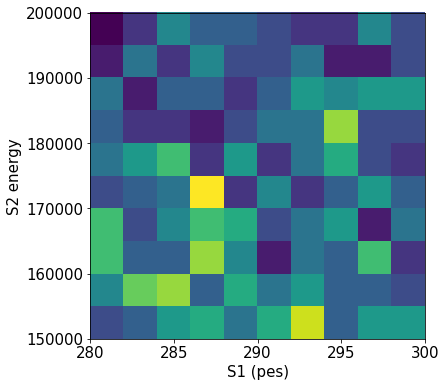

In [503]:
S1range =   280, 300
Erange = 150e3, 200e3
hist2d(PE.S1e, PE.S2e, (10, 10), range=(S1range, Erange))
labels("S1 (pes)", "S2 energy")


####  X rays

In [459]:
XR = s2eq2[s2eq2.peak ==1]
print("Ratio:", len(XR)/len(full))

Ratio: 0.10694812258936519


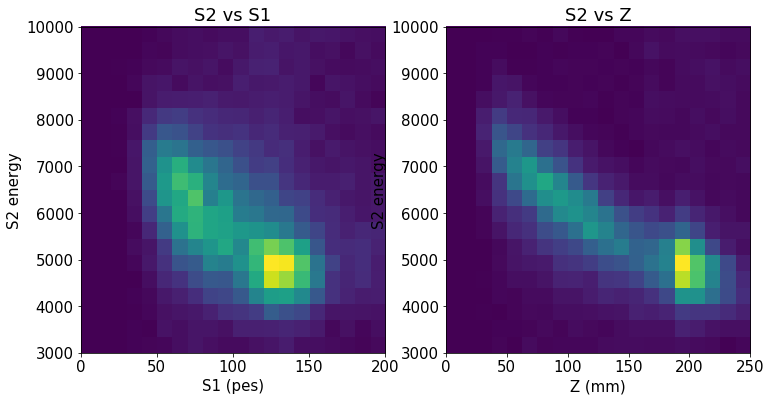

In [505]:
S1range =   0, 200
Erange = 3e3, 10e3
zrange =   0, 250

figsize=(12,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 2, 1)
plt.hist2d(XR.S1e, XR.S2e, (20, 20), range=(S1range, Erange))
labels("S1 (pes)", "S2 energy")
plt.title('S2 vs S1')

ax = plt.subplot(1, 2, 2)
plt.hist2d(XR.Z, XR.S2e, (20, 20), range=(zrange, Erange))
labels("Z (mm)", "S2 energy")
plt.title('S2 vs Z')


#### The plot above shows two components, one due to PE (S1 ~125 pes) and the other due to X rays emitted by Compton electrons with S1 in the range 50-125. This correlation plot also shows in position.

#### One can select the PE/Compton part cutting on S1

In [468]:
peXR = XR[XR.S1e >100]
print("Ratio wrt XE:", len(peXR)/len(XR))

Ratio wrt XE: 0.7596531245504798


In [470]:
cXR = XR[XR.S1e <100]
print("Ratio wrt XE:", len(cXR)/len(XR))

Ratio wrt XE: 0.24034687544952016


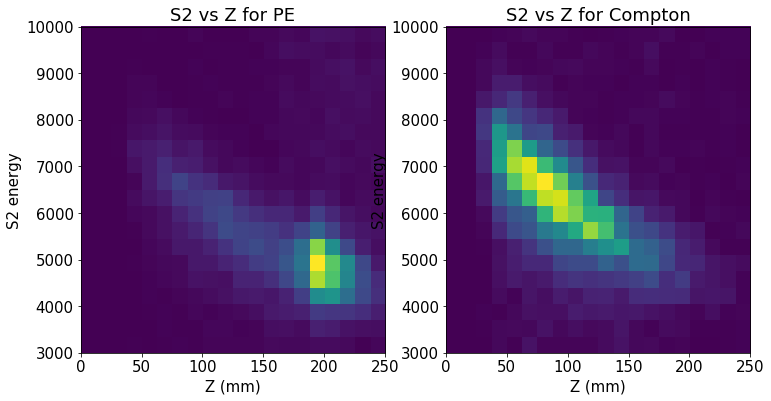

In [506]:
Erange = 3e3, 10e3
zrange =   0, 250

figsize=(12,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 2, 1)
plt.hist2d(peXR.Z, peXR.S2e, (20, 20), range=(zrange, Erange))
labels("Z (mm)", "S2 energy")
plt.title('S2 vs Z for PE')

ax = plt.subplot(1, 2, 2)
plt.hist2d(cXR.Z, cXR.S2e, (20, 20), range=(zrange, Erange))
labels("Z (mm)", "S2 energy")
plt.title('S2 vs Z for Compton')

#### One can use the Z dependence of "Compton-produced" X rays to measure electron lifetime. But notice also the different XY distributions.

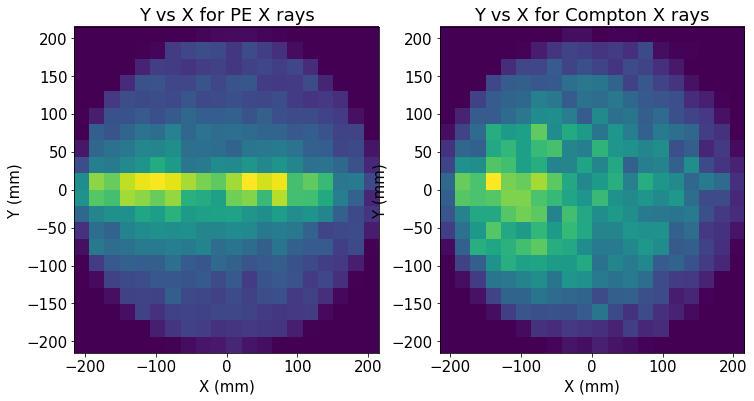

In [477]:
xrange = -215, 215
yrange = -215, 215

figsize=(12,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 2, 1)
plt.hist2d(peXR.X, peXR.Y, (20, 20), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")
plt.title('Y vs X for PE X rays')

ax = plt.subplot(1, 2, 2)
plt.hist2d(cXR.X, cXR.Y, (20, 20), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")
plt.title('Y vs X for Compton X rays')

#### PE X rays are produced more or less symmetrically through the across the line of interaction of gammas, while Compton X rays are produced by compton electrons moving towards negative X and are more spread in Y. 

### Profile histograms and fits

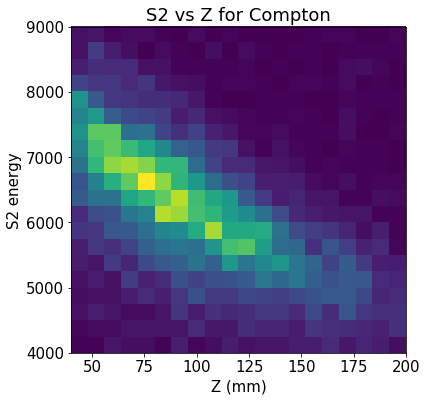

In [507]:
Erange = 4e3, 9e3
zrange =   40, 200

plt.hist2d(cXR.Z, cXR.S2e, (20, 20), range=(zrange, Erange))
labels("Z (mm)", "S2 energy")
plt.title('S2 vs Z for Compton')

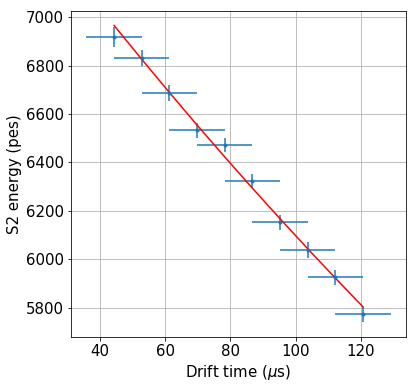

In [719]:
zrange =   40, 125
Erange = 4e+3, 8e3
nbins = 10
F, x, y, sy = profile_and_fit(cXR.Z.values, cXR.S2e.values, 
                    xrange=zrange, 
                    yrange=Erange, 
                    nbins=10, 
                    fitpar=(8e+3,-200), label=("Drift time ($\mu$s)", "S2 energy (pes)"))

In [663]:
print_fit(F)
print('chi2 = {}'.format(chi2(F, x, y, sy)))

fit par[0] = 7742.559322503727 error = 42.10807785766982
fit par[1] = -418.6628703109655 error = 11.187696317853266
degrees of freedom = 2
chi2 = 0.8070751270082483


#### Fiducialize

#### Thus, lifetime = 418 +- 11 mus

#### We now apply the correction to the full crXR set

In [720]:
zfun  = F.fn
zmin  = np.min(z)
zcorr = lambda z: zfun(zmin)/zfun(z)

In [721]:
Erange = 4e+3, 11e3
Ez = cXR.S2e * zcorr(cXR.Z)

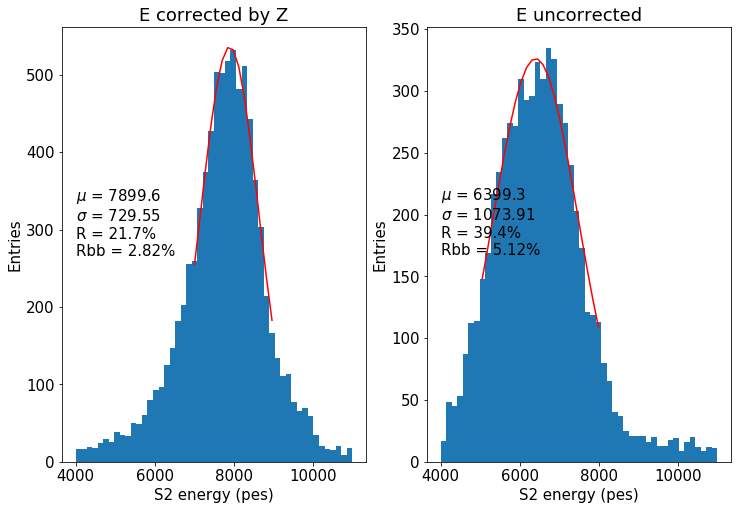

In [722]:
figsize=(12,8)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 2, 1)
y, x, _ = plt.hist(Ez, 50, range=Erange)
labels("S2 energy (pes)", "Entries")
plt.title('E corrected by Z')

x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 7000, 9000)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 8e3, 200))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f))

ax = plt.subplot(1, 2, 2)
y, x, _ = plt.hist(crXR.S2e, 50, range=Erange)
labels("S2 energy (pes)", "Entries")
plt.title('E uncorrected')

x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 5000, 8000)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 8e3, 200))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f))


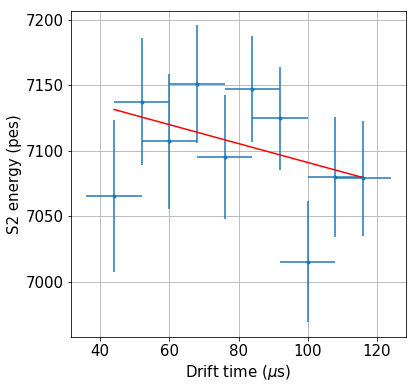

In [723]:
zrange =   40, 120
Erange = 4e+3, 8e3
nbins = 9
F2, x, y, sy = profile_and_fit(cXR.Z.values, Ez, 
                    xrange=zrange, 
                    yrange=Erange, 
                    nbins=10, 
                    fitpar=(8e+3,-10), label=("Drift time ($\mu$s)", "S2 energy (pes)"))

In [724]:
print_fit(F2)
print('chi2 = {}'.format(chi2(F2, x, y, sy)))

fit par[0] = 7163.556849719674 error = 52.241958937667796
fit par[1] = -9827.578058931625 error = 8227.574694585242
degrees of freedom = 2
chi2 = 0.7866065157914904


In [725]:
zfun2  = F2.fn
zcorr2 = lambda z: zfun2(zmin)/zfun2(z)

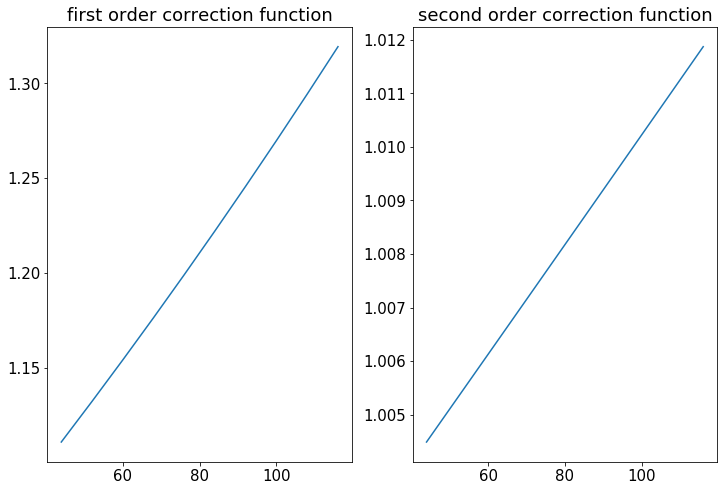

In [726]:
figsize=(12,8)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 2, 1)
plt.plot(x, zcorr(x))
plt.title('first order correction function')

ax = plt.subplot(1, 2, 2)
plt.plot(x, zcorr2(x))
plt.title('second order correction function')

In [727]:
Erange = 4e+3, 11e3
Ez2 = cXR.S2e * zcorr(cXR.Z) * zcorr2(cXR.Z)

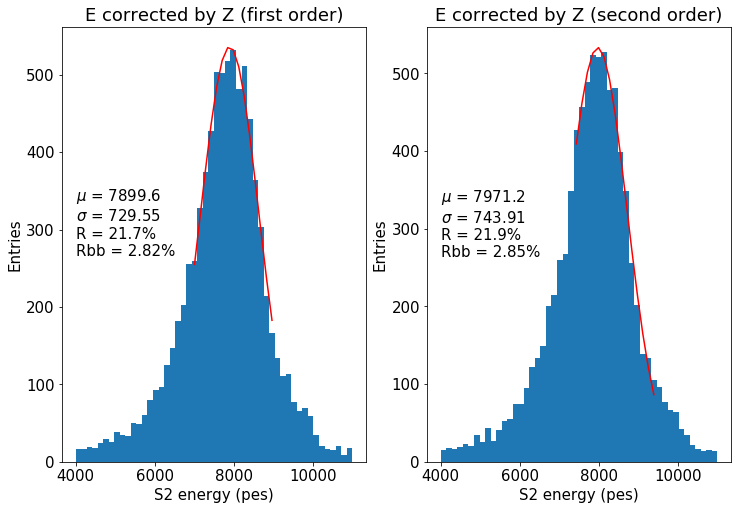

In [728]:
figsize=(12,8)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 2, 1)
y, x, _ = plt.hist(Ez, 50, range=Erange)
labels("S2 energy (pes)", "Entries")
plt.title('E corrected by Z (first order)')

x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 7000, 9000)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 8e3, 200))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f))

ax = plt.subplot(1, 2, 2)
y, x, _ = plt.hist(Ez2, 50, range=Erange)
labels("S2 energy (pes)", "Entries")
plt.title('E corrected by Z (second order)')

x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 7400, 9400)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 8e3, 200))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f))

### Geometrical corrections

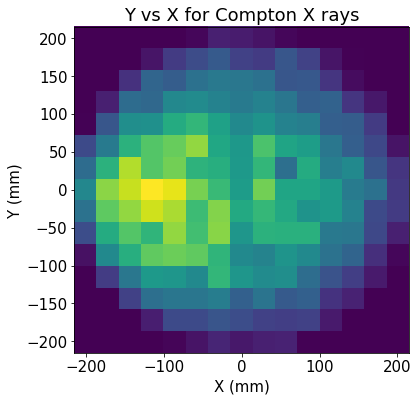

In [739]:
xrange=-215, 215
yrange=-215, 215
plot_options(figsize=(6,6), fontsize=15)
ax = plt.subplot(1, 1, 1)
plt.hist2d(cXR.X, cXR.Y, (15, 15), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")
plt.title('Y vs X for Compton X rays')

In [813]:
cXR_x1 = cXR[cXR.X < -70 ]
cXR_x2 = cXR_x1[cXR_x1.X > -130 ]
crXR = cXR_x2[abs(cXR_x2.Y) < 20 ]
print("Ratio wrt cXR:", len(crXR)/len(cXR))

Ratio wrt cXR: 0.03676470588235294


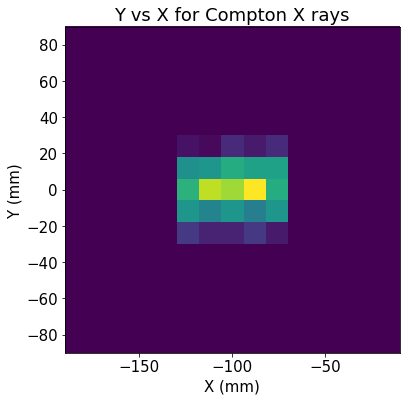

In [814]:
plot_options(figsize=(6,6), fontsize=15)
ax = plt.subplot(1, 1, 1)
plt.hist2d(crXR.X, crXR.Y, (15, 15), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")
plt.title('Y vs X for Compton X rays')

In [815]:
Erange = 4e+3, 11e3
Ez2 = crXR.S2e * zcorr(crXR.Z) 

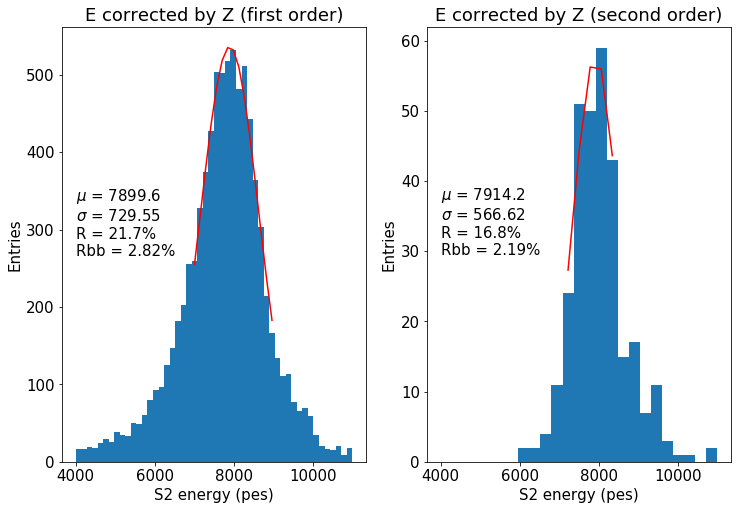

In [817]:
figsize=(12,8)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 2, 1)
y, x, _ = plt.hist(Ez, 50, range=Erange)
labels("S2 energy (pes)", "Entries")
plt.title('E corrected by Z (first order)')

x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 7000, 9000)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 8e3, 200))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f))

ax = plt.subplot(1, 2, 2)
y, x, _ = plt.hist(Ez2, 25, range=Erange)
labels("S2 energy (pes)", "Entries")
plt.title('E corrected by Z (second order)')

x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 7000, 8500)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 8e3, 200))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f))
         

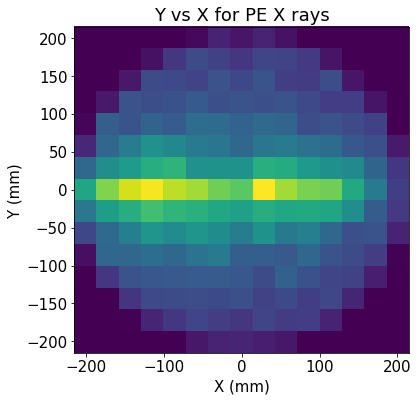

In [820]:
xrange=-215, 215
yrange=-215, 215
plot_options(figsize=(6,6), fontsize=15)
ax = plt.subplot(1, 1, 1)
plt.hist2d(peXR.X, peXR.Y, (15, 15), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")
plt.title('Y vs X for PE X rays')

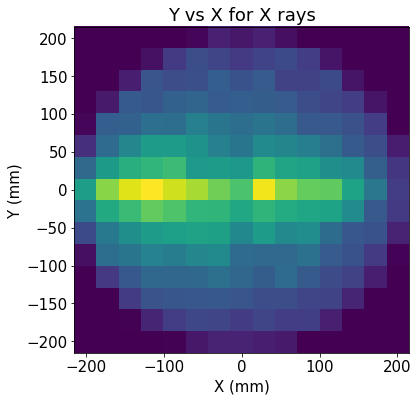

In [821]:
xrange=-215, 215
yrange=-215, 215
plot_options(figsize=(6,6), fontsize=15)
ax = plt.subplot(1, 1, 1)
plt.hist2d(XR.X, XR.Y, (15, 15), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")
plt.title('Y vs X for X rays')

In [823]:
fXR = XR[XR.R < 180 ]
print("Ratio wrt cXR:", len(fXR)/len(XR))

Ratio wrt cXR: 0.8499072085409847


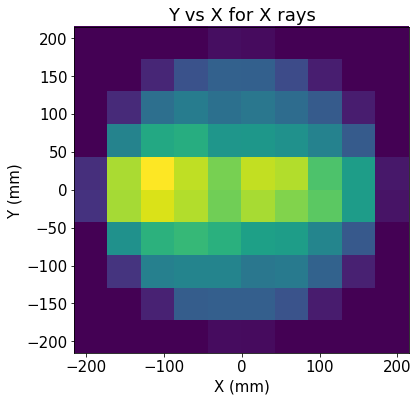

In [826]:
xrange=-215, 215
yrange=-215, 215
plot_options(figsize=(6,6), fontsize=15)
ax = plt.subplot(1, 1, 1)
plt.hist2d(fXR.X, fXR.Y, (10, 10), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")
plt.title('Y vs X for X rays')

In [831]:
Erange = 4e+3, 11e3
Ez = fXR.S2e * zcorr(fXR.Z) 
Ez2 = XR.S2e * zcorr(XR.Z) 

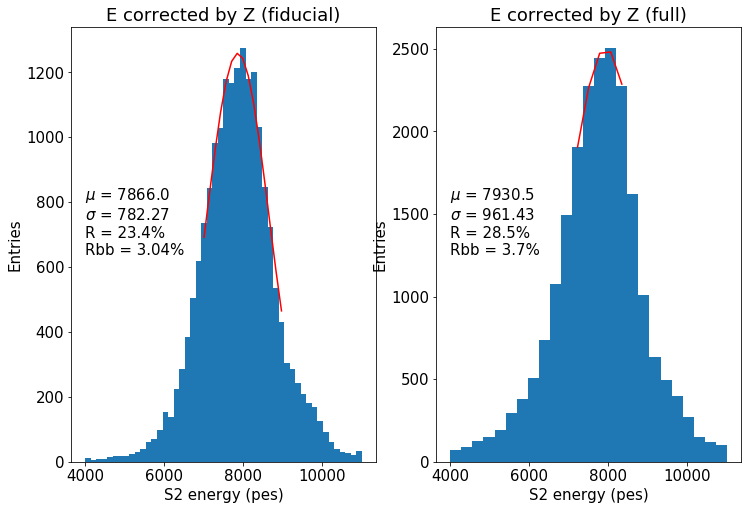

In [832]:
figsize=(12,8)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 2, 1)
y, x, _ = plt.hist(Ez, 50, range=Erange)
labels("S2 energy (pes)", "Entries")
plt.title('E corrected by Z (fiducial)')

x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 7000, 9000)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 8e3, 200))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f))

ax = plt.subplot(1, 2, 2)

y, x, _ = plt.hist(Ez2, 25, range=Erange)
labels("S2 energy (pes)", "Entries")
plt.title('E corrected by Z (full)')

x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 7000, 8500)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 8e3, 200))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f))

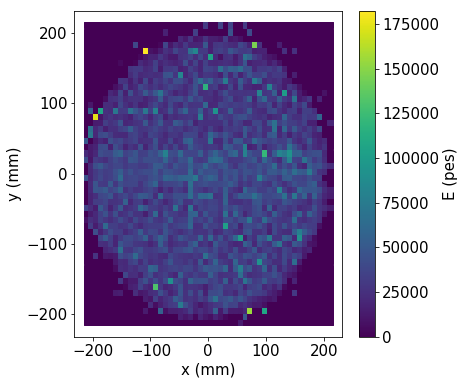

In [833]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi
Erange =  4e3, 9e3

E = XR.S2e * zcorr(XR.Z)

pf, _, cb = profile_and_scatter(XR.X, XR.Y, E, (50, 50), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")

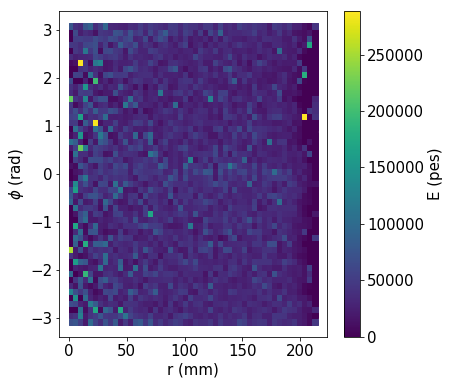

In [834]:
_, _, cb = profile_and_scatter(XR.R, XR.Phi, E, (50, 50), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")

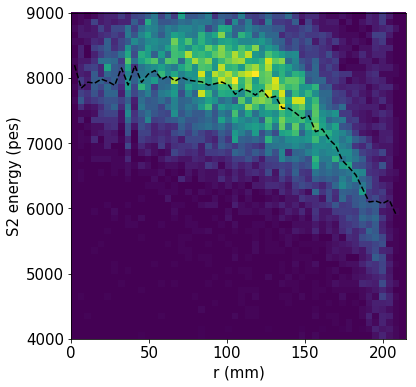

In [835]:
hist2d(XR.R, E, (50, 50), range=(rrange, Erange), weights=E)
x, y, _ = fitf.profileX(XR.R, E, 50, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")

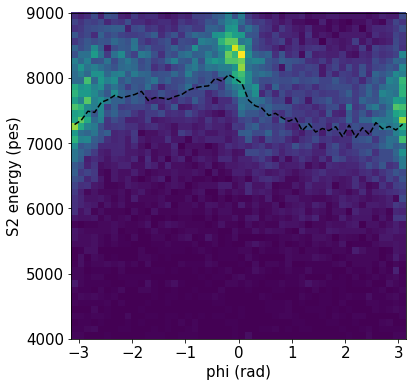

In [836]:
hist2d(XR.Phi, E, (50, 50), range=(prange, Erange), weights=E)
x, y, _ = fitf.profileX(XR.Phi, E, 50, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")

In [837]:
def get_xycorr(xs, ys, es, eref=None):
    if eref is None:
        eref = es[es.shape[0]//2, es.shape[1]//2]
    xs   = xs.reshape(xs.size, 1)
    ys   = ys.reshape(ys.size, 1)
    print(eref)
    def xycorr(x, y):
        x_closest = np.apply_along_axis(np.argmin, 0, abs(x-xs))
        y_closest = np.apply_along_axis(np.argmin, 0, abs(y-ys))
        e = es[x_closest, y_closest]
        e[e<1e3] = eref
        return eref/ e
    return xycorr
xycorr = get_xycorr(*pf[:-1])

45481.671789


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

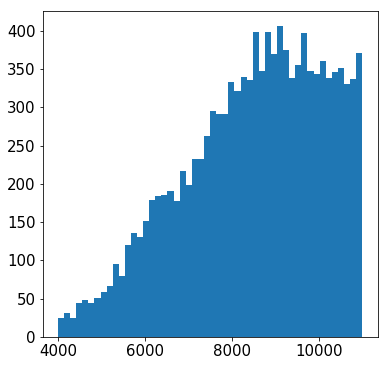

In [838]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi
Erange =  4e3, 11e3
#Erange = 6500, 7500
E  = XR.S2e * zcorr(XR.Z) * xycorr(XR.X.values, XR.Y.values)

y, x, _ = hist(E, 50, Erange)

x = x[:-1] + np.diff(x) * 0.5
f = fitf.fit(fitf.gauss, x, y, (1e5, 7e3, 5e2), fit_range=(6500, 8000))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f.values))

labels("E (pes)", "Entries")

In [ ]:




hist2d(XR.R, E, (50, 50), range=(rrange, Erange), weights=E)
x, y, _ = fitf.profileX(XR.R, E, 50, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR")

hist2d(XR.Phi, E, (50, 50), range=(prange, Erange), weights=E)
x, y, _ = fitf.profileX(XR.Phi, E, 50, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi")

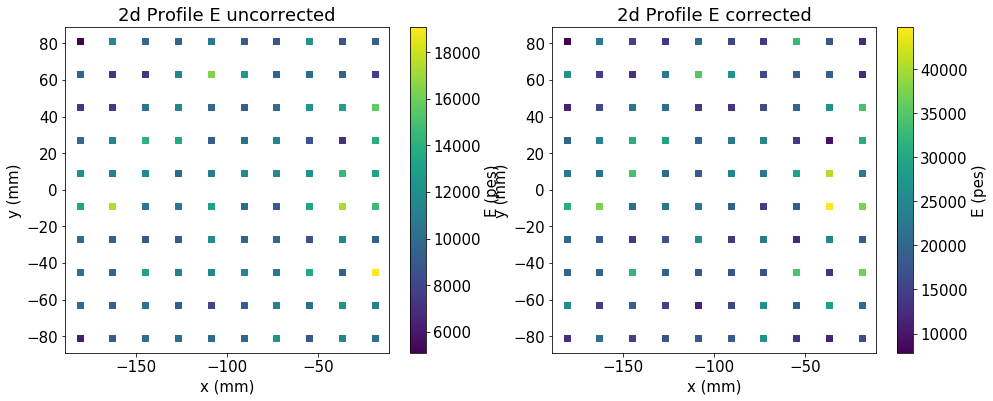

In [783]:
xrange = -100, -10
yrange = -90, 90
nbin = (10,10)
figsize=(16,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 2, 1)

x, y, E, Ee = fitf.profileXY(crXR.X, crXR.Y, crXR.S2e, *nbin, xrange=xrange, yrange=yrange)
x_ = np.repeat(x, x.size)
y_ = np.tile  (y, y.size)
z_ = E.flatten()
plt.scatter(x_, y_, c=z_, marker="s") 
cb = plt.colorbar()
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
plt.title('2d Profile E uncorrected')

ax = plt.subplot(1, 2, 2)
x, y, E, Ee = fitf.profileXY(crXR.X, crXR.Y, Ez2, *nbin, xrange=xrange, yrange=yrange)
x_ = np.repeat(x, x.size)
y_ = np.tile  (y, y.size)
z_ = E.flatten()
plt.scatter(x_, y_, c=z_, marker="s") 
cb = plt.colorbar()
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
plt.title('2d Profile E corrected')


In [784]:
E

array([[ 12804.30443867,  25793.9334146 ,  19786.72042607,  20294.00147288,
         31002.86472996,  22653.79835879,  19507.78675987,  11044.21786032,
         26776.92274697,   7819.27709421],
       [ 21157.36988431,  14344.57283883,  19621.709758  ,  18291.68356744,
         37514.8025385 ,  22044.25949316,  24708.16698265,  15945.80171829,
         14498.81780351,  23039.47019413],
       [ 14862.90610563,  18944.64334567,  32330.11536196,  13739.97750192,
         21178.08372428,  33971.02326291,  31019.71891434,  22555.97129391,
         13081.89808902,  15101.9937811 ],
       [ 17492.93140176,  14915.09712288,  19221.98123723,  17237.51791917,
         22566.16696595,  20545.22824817,  29087.40358933,  21755.6274121 ,
         22889.49498859,  13870.00517767],
       [ 17960.27075702,  11099.31050675,  17698.7839578 ,  26463.31203639,
         22739.05122951,  18403.25601674,  19588.20322845,  14279.15214307,
         34924.28102348,  20956.54745582],
       [ 18497.6055212 , 

In [770]:
eref = E[E.shape[0]//2, E.shape[1]//2]

In [771]:
eref

25094.64604279499

In [785]:
x

array([-181., -163., -145., -127., -109.,  -91.,  -73.,  -55.,  -37.,  -19.])

In [786]:
y

array([-81., -63., -45., -27.,  -9.,   9.,  27.,  45.,  63.,  81.])

In [799]:
class XYCorr:
    def __init__(self, x, y, e):
        self.xs = x.reshape(x.size, 1)
        self.ys = y.reshape(y.size, 1)
        eref = e[e.shape[0]//2, e.shape[1]//2]
        self.es = e / eref
        print(self.es)
    def xycorr(self, x, y):
        x_closest = np.apply_along_axis(np.argmin, 0, abs(x - self.xs))
        y_closest = np.apply_along_axis(np.argmin, 0, abs(y - self.ys))
        return self.es[x_closest, y_closest]
        
        

In [800]:
xyc = XYCorr(x, y, E)

[[ 0.51024049  1.027866    0.78848374  0.80869845  1.23543742  0.90273433
   0.77736848  0.44010256  1.06703728  0.31159145]
 [ 0.84310294  0.57161886  0.78190821  0.72890781  1.49493252  0.87844473
   0.98459914  0.63542644  0.57776538  0.91810302]
 [ 0.59227399  0.7549277   1.28832721  0.54752625  0.84392837  1.35371598
   1.23610904  0.898836    0.52130236  0.60180143]
 [ 0.69707823  0.59435376  0.76597937  0.68690022  0.89924229  0.81870962
   1.15910794  0.86694299  0.91212663  0.55270774]
 [ 0.7157013   0.44229795  0.70528128  1.05454016  0.90613158  0.73335388
   0.780573    0.5690119   1.39170248  0.83510034]
 [ 0.73711363  0.64354423  0.68969284  0.54564611  0.75687298  1.
   0.89918718  0.5402764   1.07725449  0.6280261 ]
 [ 1.07052229  1.05309578  0.67732971  0.92456361  0.56375154  0.90753788
   1.0037415   0.64659778  0.63929576  0.55195185]
 [ 0.54152379  0.7406733   1.37254146  0.48350203  0.73623028  1.14369771
   0.5534032   0.79805556  0.75939157  1.30274682]
 [ 0.454

In [788]:
xyc.xs

array([[-181.],
       [-163.],
       [-145.],
       [-127.],
       [-109.],
       [ -91.],
       [ -73.],
       [ -55.],
       [ -37.],
       [ -19.]])

In [789]:
xyc.ys

array([[-81.],
       [-63.],
       [-45.],
       [-27.],
       [ -9.],
       [  9.],
       [ 27.],
       [ 45.],
       [ 63.],
       [ 81.]])

In [793]:
x_closest = np.apply_along_axis(np.argmin, 0, abs(crXR.X.values - xyc.xs))

In [794]:
y_closest = np.apply_along_axis(np.argmin, 0, abs(crXR.Y.values - xyc.ys))

In [795]:
xyc.es[x_closest, y_closest]

array([ 0.59435376,  0.54752625,  0.54752625, ...,  0.73623028,
        0.90613158,  0.44229795])

In [768]:
Ec  = crXR.S2e.values * zcorr(crXR.Z) * xyc.xycorr(crXR.X.values, crXR.Y.values)

In [797]:
crXR.S2e.values * zcorr(crXR.Z.values)

array([  8035.42438612,   7456.34361646,  49309.90002413, ...,
         8254.80280959,   6806.16140032,   7133.51338322])

In [801]:
Ec = crXR.S2e.values * zcorr(crXR.Z.values) * xyc.es[x_closest, y_closest]

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

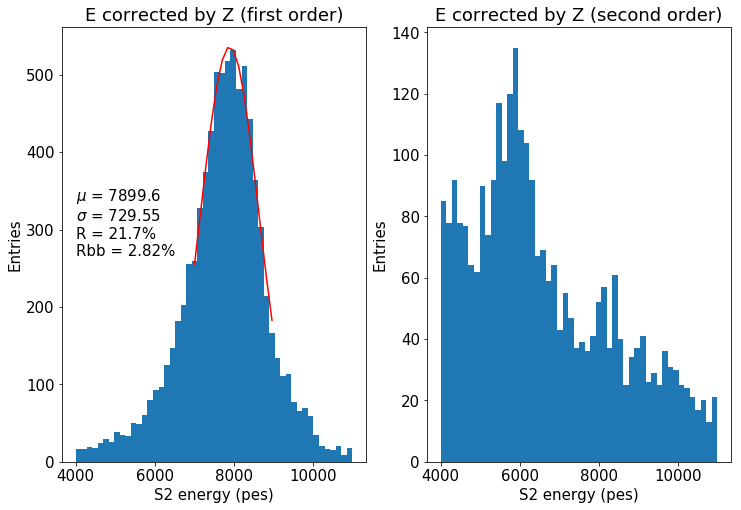

In [802]:
figsize=(12,8)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 2, 1)
y, x, _ = plt.hist(Ez, 50, range=Erange)
labels("S2 energy (pes)", "Entries")
plt.title('E corrected by Z (first order)')

x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 7000, 9000)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 8e3, 200))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f))

ax = plt.subplot(1, 2, 2)
y, x, _ = plt.hist(Ec, 50, range=Erange)
labels("S2 energy (pes)", "Entries")
plt.title('E corrected by Z (second order)')

x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 7000, 8500)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 8e3, 200))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f))

In [712]:
x.reshape(x.size, 1)

array([[-126.],
       [ -98.],
       [ -70.],
       [ -42.],
       [ -14.],
       [  14.],
       [  42.],
       [  70.],
       [  98.],
       [ 126.]])

In [713]:
eref = E[E.shape[0]//2, E.shape[1]//2]

In [714]:
eref

17773.294561715484

In [ ]:
pf, _, cb = profile_and_scatter(crXR.X, crXR.Y, crXR.S2e, (20, 20), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
plt.title('2d Profile E uncorrected')

ax = plt.subplot(1, 2, 2)
pf, _, cb = profile_and_scatter(crXR.X, crXR.Y, E, (20, 20), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
plt.title('2d Profile E corrected by attachment')

x, y, z, ze = fitf.profileXY(crXR.X, crXR.Y, Ez2, *nbin, xrange=xrange, yrange=yrange)
def get_xycorr(xs, ys, es, eref=None):
    if eref is None:
        eref = es[es.shape[0]//2, es.shape[1]//2]
    xs   = xs.reshape(xs.size, 1)
    ys   = ys.reshape(ys.size, 1)
    print(eref)
    def xycorr(x, y):
        x_closest = np.apply_along_axis(np.argmin, 0, abs(x-xs))
        y_closest = np.apply_along_axis(np.argmin, 0, abs(y-ys))
        e = es[x_closest, y_closest]
        e[e<1e3] = eref
        return eref/ e
    return xycorr
xycorr = get_xycorr(*pf[:-1])

In [ ]:
peXR = XR[XR.S1e >100]
print("Ratio wrt XE:", len(peXR)/len(XR))

In [285]:
s1cXR = XR[XR.S1e <70]
print("Ratio:", len(s1cXR)/len(full))
s1cXR.head()

Ratio: 0.008900916270792581


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
33,38,1.491674e+09,1,2,150.0,14.287548,67.987579,606650.0,11.124375,547.778259,...,783687.5,1.0,177.0375,177.0375,-205.000000,-15.000000,205.548048,-3.068552,0.000000,0.000000
46,51,1.491674e+09,1,2,150.0,13.202993,63.658347,617375.0,5.129375,2506.131836,...,677912.5,4.0,60.5375,60.5375,-124.605900,-57.050477,137.045202,-2.712232,5.692910,4.045706
209,222,1.491674e+09,1,2,175.0,11.065803,58.131457,634575.0,9.079625,1147.028442,...,1256937.5,1.0,622.3625,622.3625,-85.000000,95.000000,127.475488,2.300696,0.000000,0.000000
319,333,1.491674e+09,1,2,150.0,10.558423,52.607425,626750.0,5.023438,2293.554688,...,686687.5,4.0,59.9375,59.9375,-138.539810,-30.162793,141.785306,-2.927219,4.792442,5.008226
387,400,1.491674e+09,1,2,250.0,11.551735,69.007702,633700.0,4.361688,3391.495117,...,669612.5,5.0,35.9125,35.9125,3.795978,-40.973047,41.148512,-1.478414,5.992984,4.914148


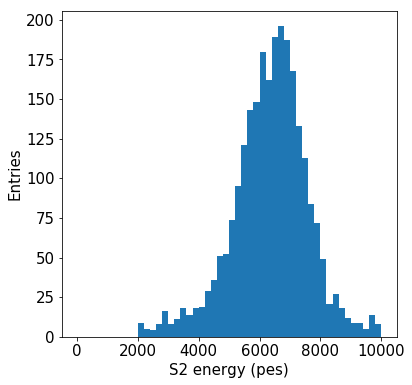

In [338]:
hist(s1cXR.S2e, 50, (0e3,1e+4))
labels("S2 energy (pes)", "Entries")

### Dependence with Z

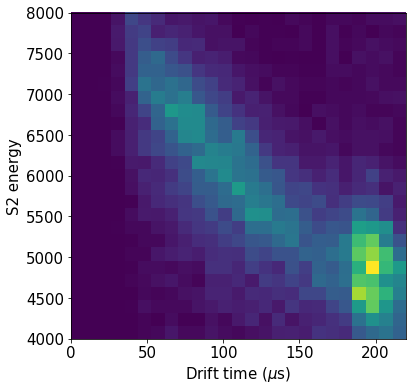

In [339]:
zrange =   0, 220
Erange = 4e+3, 8e3
hist2d(XR.Z, XR.S2e, (25, 25), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")



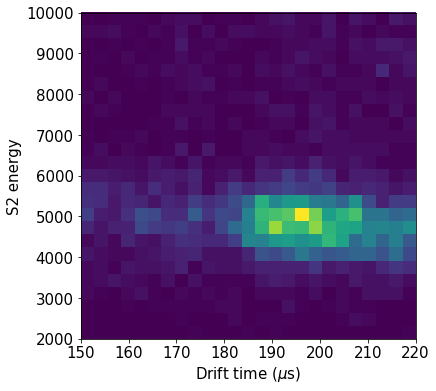

In [387]:
zrange =   150, 220
Erange = 2e+3, 1e4
hist2d(s1XR.Z, s1XR.S2e, (25, 25), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")



#### Histogram above are supposed to be x-rays from PE interactions. They occur at a fixed position and thus, they all drift the same. 

#### Histogram below is supposed to be due to Compton-induced X rays. They are distributed 

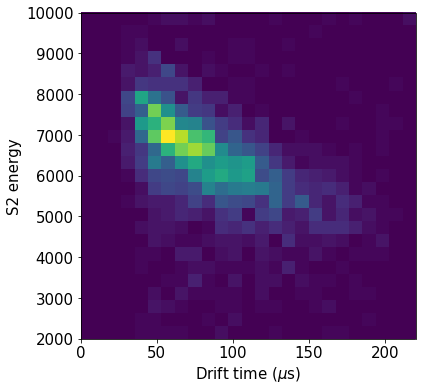

In [353]:
zrange =   0, 220
Erange = 2e+3, 1e+4
nbins = 10
ze = (zrange[1] - zrange[0])/nbins
hist2d(s1cXR.Z, s1cXR.S2e, (25, 25), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")



In [354]:
zrange =   40, 100
Erange = 4e+3, 8e3
nbins = 10
ze = (zrange[1] - zrange[0])/nbins

In [355]:
zrange =   40, 100
Erange = 4e+3, 8e3
nbins = 10
ze = (zrange[1] - zrange[0])/nbins
z, E, Ee = fitf.profileX(s1cXR.Z.values, s1cXR.S2e.values, nbins=nbins,
             xrange=zrange, yrange=Erange, drop_nan=True)

sel  = fitf.in_range(z, zrange[0], zrange[1])
z, E, Ee = z[sel], E[sel], Ee[sel]
plt.errorbar(x=z, xerr=ze, y=E, yerr=Ee,
                 linestyle='none', marker='.')

<Container object of 3 artists>

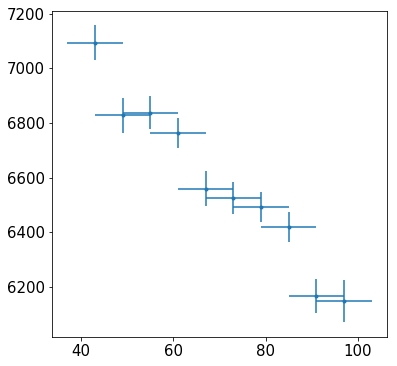

In [356]:
plt.errorbar(x=z, xerr=ze, y=E, yerr=Ee,
                 linestyle='none', marker='.')

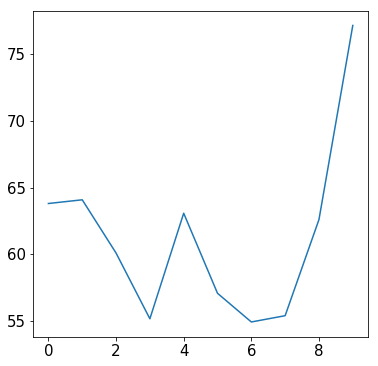

In [357]:
plt.plot(Ee)

In [331]:
Ee = np.repeat(35,10)

In [358]:
f = fitf.fit(fitf.expo, z, E, (1e4, -200), sigma=Ee)


fit values: E0 = 7808.292871574346 lifetime = -410.17514447400816
errors: E0 = 107.77840881232183 lifetime = 33.04676884965736
chi2 = 0.6809144396954698


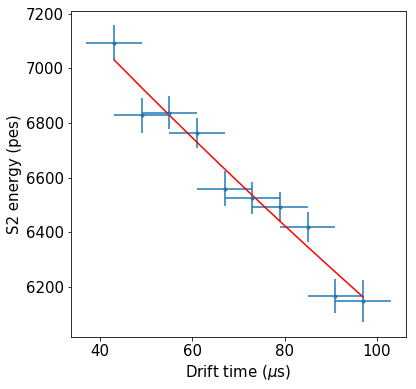

In [359]:
plt.errorbar(x=z, xerr=ze, y=E, yerr=Ee,
                 linestyle='none', marker='.')
plt.plot(z, f.fn(z), fitOpt)
print('fit values: E0 = {} lifetime = {}'.format(f.values[0],f.values[1]))
print('errors: E0 = {} lifetime = {}'.format(f.errors[0],f.errors[1]))
print('chi2 = {}'.format(f.chi2))
labels("Drift time ($\mu$s)", "S2 energy (pes)")

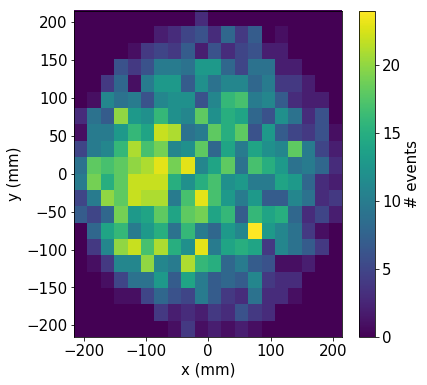

In [360]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi
nevts, xs, ys, _ = \
hist2d(s1cXR.X, s1cXR.Y, (20, 20), range=(xrange, yrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)")



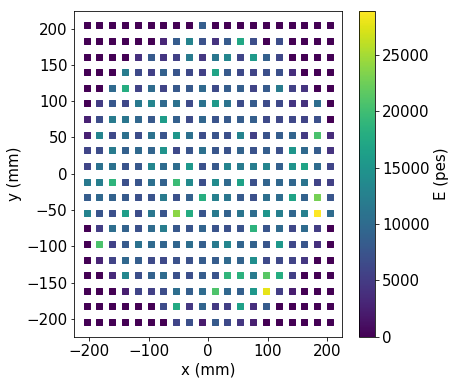

In [361]:
pf, _, cb = profile_and_scatter(s1cXR.X, s1cXR.Y, s1cXR.S2e, (20, 20), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")

In [436]:
zfPE1 = PE[PE.Z > 165]
zfPE = zfPE1[zfPE1.Z < 185]
print("Ratio wrt full:", len(zfPE)/len(full))
print("Ratio wrt PE:", len(zfPE)/len(PE))

Ratio wrt full: 0.018168631803347143
Ratio wrt PE: 0.16988266239237204


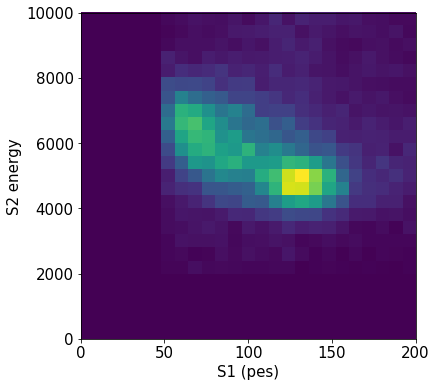

In [287]:
S1range =   0, 200
Erange = (0e3,1e+4)
hist2d(XR.S1e, XR.S2e, (25, 25), range=(S1range, Erange))
labels("S1 (pes)", "S2 energy")

In [363]:
s1cXRx = s1cXR[s1cXR.X <0]
s1cXRxy = s1cXRx[abs(s1cXRx.Y) <100]
print("Ratio:", len(s1cXRxy)/len(full))
s1cXRxy.head()

Ratio: 0.0038445134057917725


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
33,38,1.491674e+09,1,2,150.0,14.287548,67.987579,606650.0,11.124375,547.778259,...,783687.5,1.0,177.0375,177.0375,-205.000000,-15.000000,205.548048,-3.068552,0.000000,0.000000
46,51,1.491674e+09,1,2,150.0,13.202993,63.658347,617375.0,5.129375,2506.131836,...,677912.5,4.0,60.5375,60.5375,-124.605900,-57.050477,137.045202,-2.712232,5.692910,4.045706
209,222,1.491674e+09,1,2,175.0,11.065803,58.131457,634575.0,9.079625,1147.028442,...,1256937.5,1.0,622.3625,622.3625,-85.000000,95.000000,127.475488,2.300696,0.000000,0.000000
319,333,1.491674e+09,1,2,150.0,10.558423,52.607425,626750.0,5.023438,2293.554688,...,686687.5,4.0,59.9375,59.9375,-138.539810,-30.162793,141.785306,-2.927219,4.792442,5.008226
432,446,1.491674e+09,1,2,175.0,11.828390,66.648164,624025.0,8.334375,4966.333008,...,1065587.5,8.0,441.5625,441.5625,-142.860011,-21.896612,144.528352,-2.989503,6.895839,6.799028


<Container object of 3 artists>

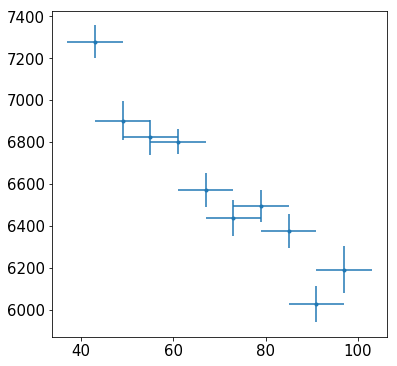

In [366]:
z, E, Ee = fitf.profileX(s1cXRxy.Z.values, s1cXRxy.S2e.values, nbins=nbins,
             xrange=zrange, yrange=Erange, drop_nan=True)

sel  = fitf.in_range(z, zrange[0], zrange[1])
z, E, Ee = z[sel], E[sel], Ee[sel]
plt.errorbar(x=z, xerr=ze, y=E, yerr=Ee,
                 linestyle='none', marker='.')

In [367]:
f = fitf.fit(fitf.expo, z, E, (1e4, -200), sigma=Ee)

fit values: E0 = 8168.01842518911 lifetime = -325.50177607191466
errors: E0 = 178.64589878349796 lifetime = 33.85000811550618
chi2 = 1.9848546995150036


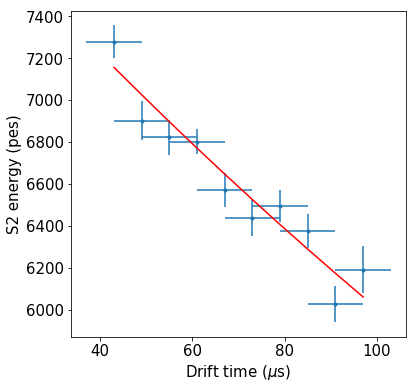

In [368]:
plt.errorbar(x=z, xerr=ze, y=E, yerr=Ee,
                 linestyle='none', marker='.')
plt.plot(z, f.fn(z), fitOpt)
print('fit values: E0 = {} lifetime = {}'.format(f.values[0],f.values[1]))
print('errors: E0 = {} lifetime = {}'.format(f.errors[0],f.errors[1]))
print('chi2 = {}'.format(f.chi2))
labels("Drift time ($\mu$s)", "S2 energy (pes)")

#### Large uncertainties in fit with this subset

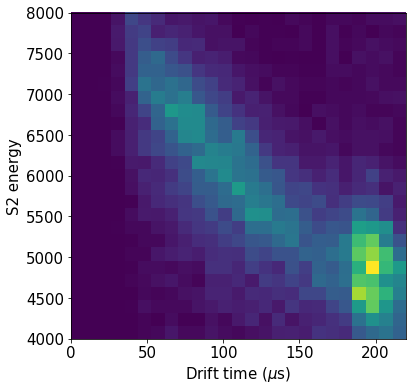

In [369]:
zrange =   0, 220
Erange = 4e+3, 8e3
hist2d(XR.Z, XR.S2e, (25, 25), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")


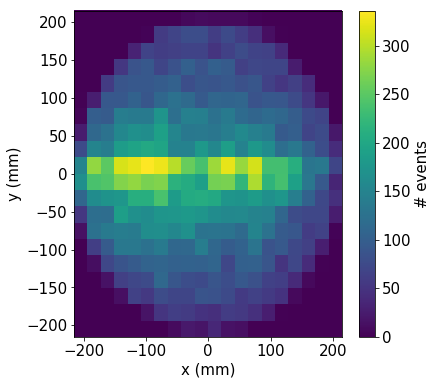

In [370]:
hist2d(XR.X, XR.Y, (20, 20), range=(xrange, yrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)")



In [371]:
zXR1 = XR[XR.Z >40]
zXR =  zXR1[zXR1.Z < 150]
print("Ratio:", len(zXR)/len(full))
s1cXRxy.head()

Ratio: 0.033312252731898875


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
33,38,1.491674e+09,1,2,150.0,14.287548,67.987579,606650.0,11.124375,547.778259,...,783687.5,1.0,177.0375,177.0375,-205.000000,-15.000000,205.548048,-3.068552,0.000000,0.000000
46,51,1.491674e+09,1,2,150.0,13.202993,63.658347,617375.0,5.129375,2506.131836,...,677912.5,4.0,60.5375,60.5375,-124.605900,-57.050477,137.045202,-2.712232,5.692910,4.045706
209,222,1.491674e+09,1,2,175.0,11.065803,58.131457,634575.0,9.079625,1147.028442,...,1256937.5,1.0,622.3625,622.3625,-85.000000,95.000000,127.475488,2.300696,0.000000,0.000000
319,333,1.491674e+09,1,2,150.0,10.558423,52.607425,626750.0,5.023438,2293.554688,...,686687.5,4.0,59.9375,59.9375,-138.539810,-30.162793,141.785306,-2.927219,4.792442,5.008226
432,446,1.491674e+09,1,2,175.0,11.828390,66.648164,624025.0,8.334375,4966.333008,...,1065587.5,8.0,441.5625,441.5625,-142.860011,-21.896612,144.528352,-2.989503,6.895839,6.799028


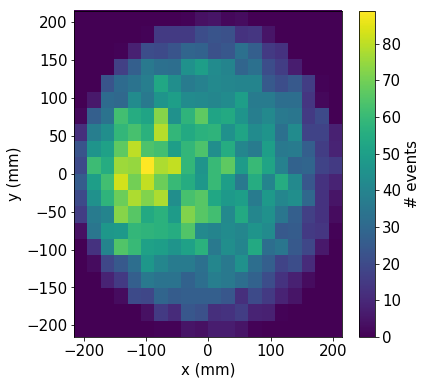

In [372]:
hist2d(zXR.X, zXR.Y, (20, 20), range=(xrange, yrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)")


In [373]:
xzXR1 = zXR[zXR.X > -150]
xzXR =  xzXR1[xzXR1.X < -50]
xyzXR = xzXR[abs(xzXR.Y) <100]
print("Ratio:", len(xyzXR)/len(full))
xyzXR.head()

Ratio: 0.00805671172032415


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
46,51,1.491674e+09,1,2,150.0,13.202993,63.658347,617375.0,5.129375,2506.131836,...,677912.5,4.0,60.5375,60.5375,-124.605900,-57.050477,137.045202,-2.712232,5.692910,4.045706
319,333,1.491674e+09,1,2,150.0,10.558423,52.607425,626750.0,5.023438,2293.554688,...,686687.5,4.0,59.9375,59.9375,-138.539810,-30.162793,141.785306,-2.927219,4.792442,5.008226
560,595,1.491674e+09,1,2,150.0,16.547794,79.926518,639500.0,4.860688,2494.254150,...,698687.5,3.0,59.1875,59.1875,-117.174728,-31.651475,121.374350,-2.877767,4.135782,4.731416
591,621,1.491674e+09,1,2,175.0,12.525636,61.303479,595275.0,5.731750,2021.592407,...,671012.5,2.0,75.7375,75.7375,-95.000000,51.277277,107.955357,2.646645,0.000000,4.855275
614,646,1.491674e+09,1,2,250.0,47.166218,258.221039,639075.0,15.801438,7175.094238,...,711412.5,14.0,72.3375,72.3375,-62.781742,97.519893,115.981363,2.142789,78.883443,16.804122


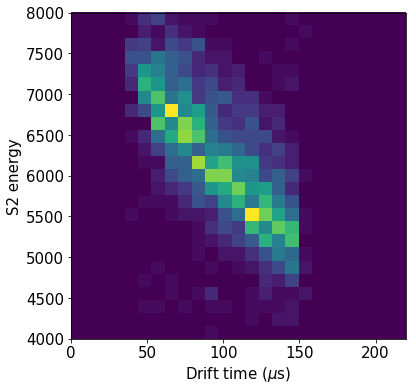

In [374]:
hist2d(xyzXR.Z, xyzXR.S2e, (25, 25), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")

<Container object of 3 artists>

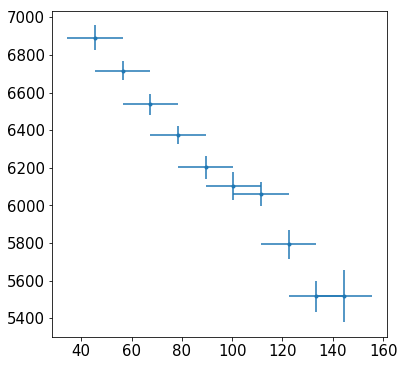

In [375]:
zrange =   40, 150
Erange = 45e+2, 75e2
nbins = 10
ze = (zrange[1] - zrange[0])/nbins
z, E, Ee = fitf.profileX(s1cXRxy.Z.values, s1cXRxy.S2e.values, nbins=nbins,
             xrange=zrange, yrange=Erange, drop_nan=True)

sel  = fitf.in_range(z, zrange[0], zrange[1])
z, E, Ee = z[sel], E[sel], Ee[sel]
plt.errorbar(x=z, xerr=ze, y=E, yerr=Ee,
                 linestyle='none', marker='.')

In [376]:
f = fitf.fit(fitf.expo, z, E, (1e4, -200), sigma=Ee)

fit values: E0 = 7624.5575957516985 lifetime = -444.4210886596579
errors: E0 = 73.39918332565082 lifetime = 22.331210395667455
chi2 = 0.7611027020569432


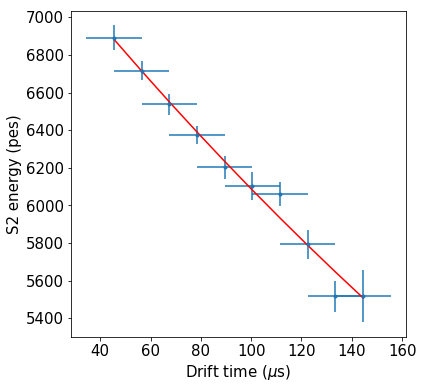

In [377]:
plt.errorbar(x=z, xerr=ze, y=E, yerr=Ee,
                 linestyle='none', marker='.')
plt.plot(z, f.fn(z), fitOpt)
print('fit values: E0 = {} lifetime = {}'.format(f.values[0],f.values[1]))
print('errors: E0 = {} lifetime = {}'.format(f.errors[0],f.errors[1]))
print('chi2 = {}'.format(f.chi2))
labels("Drift time ($\mu$s)", "S2 energy (pes)")

In [378]:
zfun  = f.fn
zmin  = np.min(z)
zcorr = lambda z: zfun(zmin)/zfun(z)

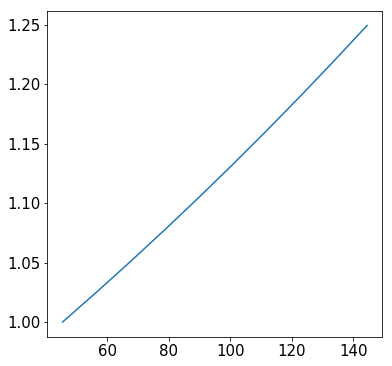

In [379]:
plt.plot(z, zcorr(z))

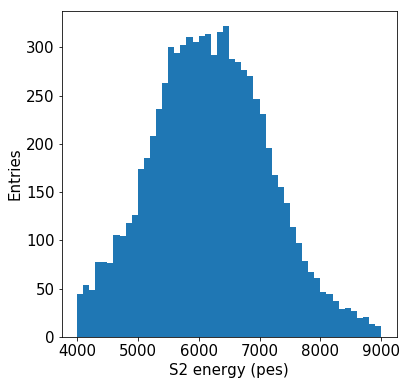

In [383]:
Erange = 4e3, 9e3
hist(zXR.S2e, 50, range=Erange)
labels("S2 energy (pes)", "Entries")

In [ ]:
E = zXR.S2e * zcorr(zXR.Z)

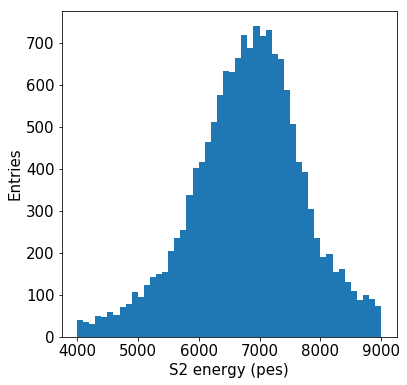

In [384]:
E = XR.S2e * zcorr(XR.Z)
y, x, _ = hist(E, 50, range=Erange)
labels("S2 energy (pes)", "Entries")

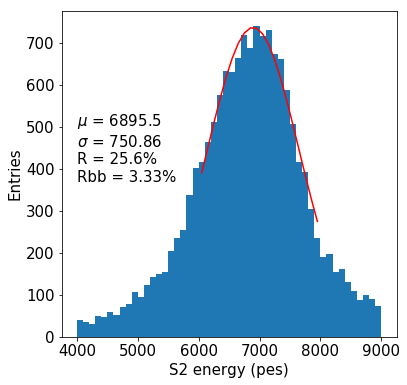

In [386]:
E = XR.S2e * zcorr(XR.Z)
y, x, _ = hist(E, 50, range=Erange)
labels("S2 energy (pes)", "Entries")
x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 6000, 8000)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 8e3, 200))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f))

In [388]:
z2XR1 = XR[XR.Z >180]
z2XR =  z2XR1[z2XR1.Z < 220]
print("Ratio:", len(z2XR)/len(full))

Ratio: 0.020940390922594972


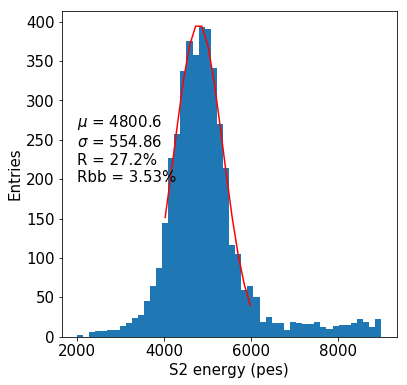

In [394]:
Erange = 2e3, 9e3
y, x, _ = hist(z2XR.S2e, 50, range=Erange)
labels("S2 energy (pes)", "Entries")
x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 4000, 6000)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 5e3, 200))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f))

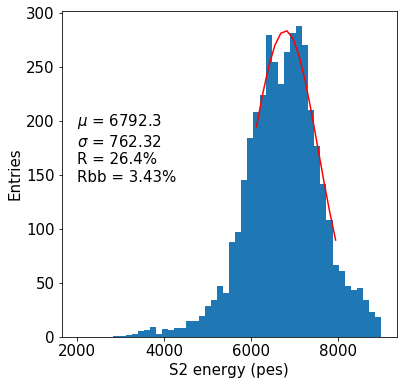

In [391]:
E = z2XR.S2e * zcorr(z2XR.Z)
y, x, _ = hist(E, 50, range=Erange)
labels("S2 energy (pes)", "Entries")
x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 6000, 8000)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 8e3, 200))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f))

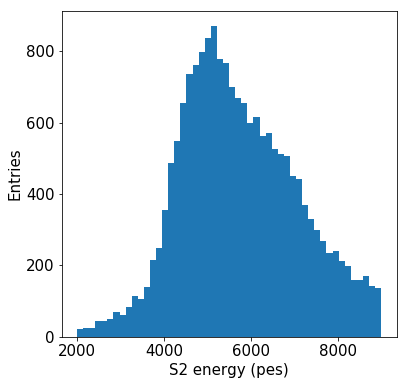

In [395]:
Erange = 2e3, 9e3
y, x, _ = hist(XR.S2e, 50, range=Erange)
labels("S2 energy (pes)", "Entries")

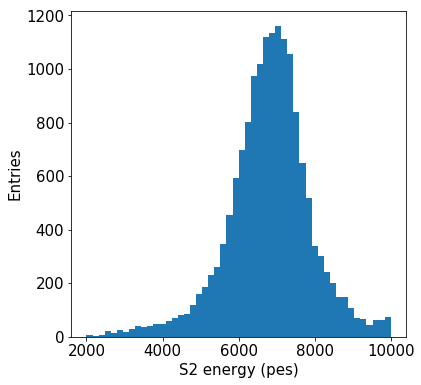

In [397]:
Erange = 2e3, 10e3
E = XR.S2e * zcorr(XR.Z)
y, x, _ = hist(E, 50, range=Erange)
labels("S2 energy (pes)", "Entries")

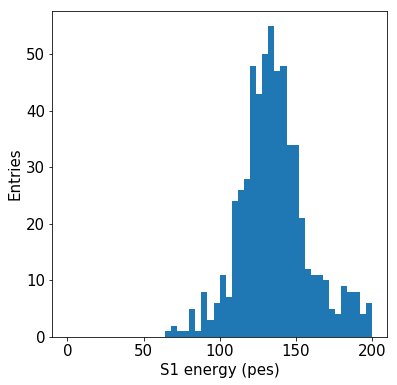

In [256]:
hist(zfPE.S1e, 50, (0,200))
labels("S1 energy (pes)", "Entries")

In [259]:
zs1fPE1 = zfPE[zfPE.S1e > 130]
zs1fPE = zs1fPE1[zs1fPE1.S1e < 150]
print("Ratio:", len(zs1fPE)/len(full))
zfPE.head()

Ratio: 0.0006735987528127895


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
164,172,1.491674e+09,0,2,225.0,35.584572,194.989060,494925.0,23.228625,10212.998047,...,666387.5,25.0,171.4625,171.4625,111.392529,-1.561614,111.403475,-0.014018,10.478048,10.062891
580,612,1.491674e+09,0,2,200.0,19.673143,110.190562,492925.0,20.060688,9975.156250,...,663712.5,26.0,170.7875,170.7875,-83.247837,0.354452,83.248592,3.137335,13.169871,9.024412
750,798,1.491674e+09,0,2,225.0,31.129942,165.690086,487250.0,20.488125,8981.559570,...,658037.5,25.0,170.7875,170.7875,-5.978484,-18.664402,19.598525,-1.880785,9.521331,11.545757
933,981,1.491674e+09,0,2,200.0,21.642958,110.233346,484375.0,15.458937,9871.678711,...,655712.5,28.0,171.3375,171.3375,90.198711,44.940530,100.774296,0.462238,11.129120,13.043243
1206,1265,1.491674e+09,0,2,225.0,21.334745,113.287581,494775.0,21.613625,11977.113281,...,665087.5,24.0,170.3125,170.3125,-10.472043,-10.038003,14.506039,-2.377354,11.489206,9.230755


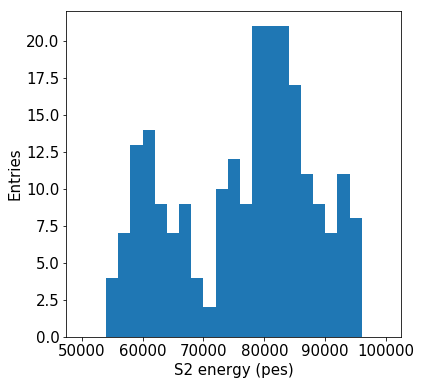

In [263]:
hist(zs1fPE.S2e, 25, (50e+3,100e3))
labels("S2 energy (pes)", "Entries")

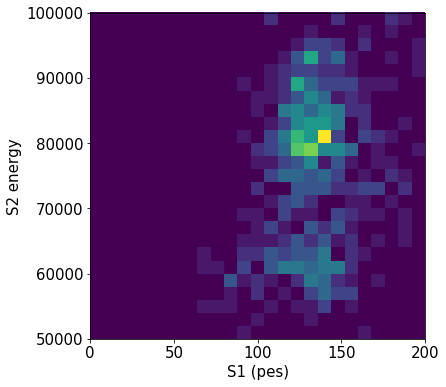

In [255]:
S1range =   0, 200
Erange = 5e4, 1e5
hist2d(zfPE.S1e, zfPE.S2e, (25, 25), range=(S1range, Erange))
labels("S1 (pes)", "S2 energy")



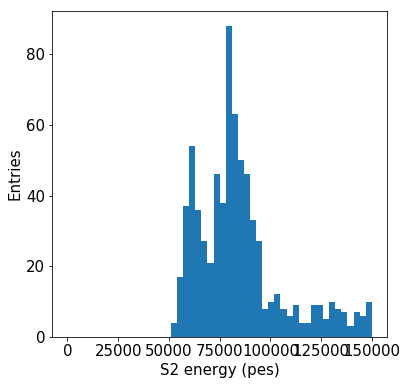

In [258]:
hist(zfPE.S2e, 50, (0e3,15e4))
labels("S2 energy (pes)", "Entries")

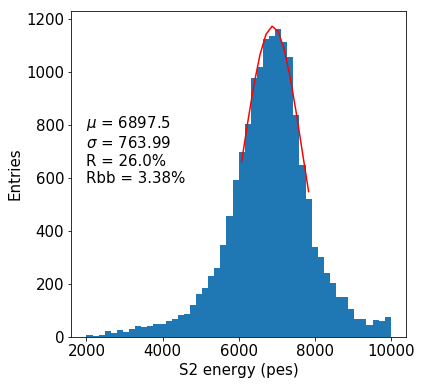

In [398]:
Erange = 2e3, 10e3
E = XR.S2e * zcorr(XR.Z)
y, x, _ = hist(E, 50, range=Erange)
labels("S2 energy (pes)", "Entries")
x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 6000, 8000)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 7e3, 200))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f))

### Now take all the sample

In [249]:
zf1 = full[full.Z > 170]
zf = full[full.Z < 172]
print("Ratio:", len(zf)/len(full))
zf.head()

Ratio: 0.7020310914358832


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,1,1.491674e+09,0,1,275.0,49.620018,287.162550,537150.0,40.100437,13367.398438,...,657112.5,54.0,119.9625,119.9625,97.811136,40.847802,105.997930,0.395602,25.243436,11.175782
1,2,1.491674e+09,0,1,200.0,24.205078,129.749825,557000.0,38.343750,10287.787109,...,653687.5,25.0,96.6875,96.6875,136.927309,5.200002,137.026012,0.037958,9.209800,10.444016
3,5,1.491674e+09,0,2,225.0,54.494896,286.139376,615225.0,45.152500,10520.092773,...,672387.5,54.0,57.1625,57.1625,-21.676225,165.445635,166.859572,1.701072,15.885687,18.841620
6,8,1.491674e+09,0,1,325.0,31.736614,165.305724,636875.0,31.787500,34261.953125,...,661412.5,47.0,24.5375,24.5375,-15.939325,-11.792324,19.827279,-2.504635,21.752563,23.834757
7,9,1.491674e+09,0,1,225.0,26.748526,159.692408,489400.0,23.693750,8325.739258,...,657437.5,25.0,168.0375,168.0375,93.885652,22.494355,96.542797,0.235160,10.005769,11.830000


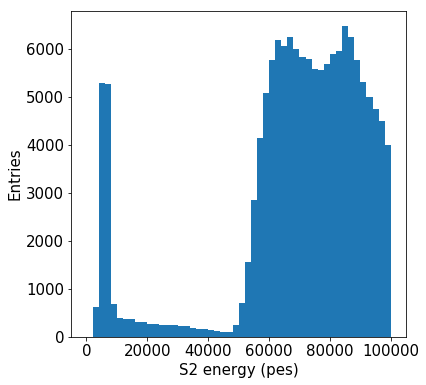

In [250]:
hist(zf.S2e, 50, (0e3,1e5))
labels("S2 energy (pes)", "Entries")

#### The peak now gets contributions from Compton interactions of the 1.2 MeV gamma

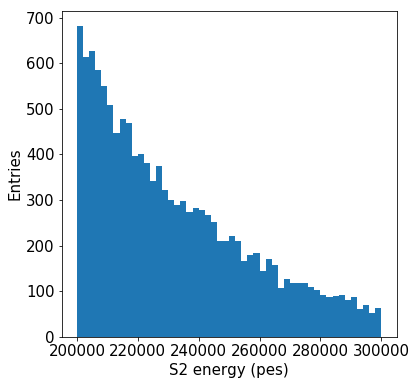

In [269]:
hist(zf.S2e, 50, (2.0e5,3.0e5))
labels("S2 energy (pes)", "Entries")

In [206]:
s2eq2p0zlt15 = s2eq2p0[s2eq2p0.Z < 150]
s2eq2p0zlt15.head()

,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
3,5,1.491674e+09,0,2,225.0,54.494896,286.139376,615225.0,45.152500,10520.092773,...,672387.5,54.0,57.1625,57.1625,-21.676225,165.445635,166.859572,1.701072,15.885687,18.841620
18,20,1.491674e+09,0,2,225.0,37.718376,217.355925,530875.0,36.222500,11878.065430,...,655912.5,59.0,125.0375,125.0375,48.661950,-86.593677,99.330007,-1.058819,27.819668,13.258652
32,38,1.491674e+09,0,2,150.0,14.287548,67.987579,606650.0,11.080000,12572.112305,...,657387.5,18.0,50.7375,50.7375,22.448518,-94.719632,97.343437,-1.338090,8.182807,8.481033
36,41,1.491674e+09,0,2,250.0,35.366230,188.548965,554525.0,16.371625,19231.455078,...,657187.5,41.0,102.6625,102.6625,-117.055839,-13.136582,117.790659,-3.029835,13.710427,11.128306
45,51,1.491674e+09,0,2,150.0,13.202993,63.658347,617375.0,11.054375,19796.833984,...,656437.5,23.0,39.0625,39.0625,-64.979138,-113.096915,130.434660,-2.092288,8.982178,9.346743


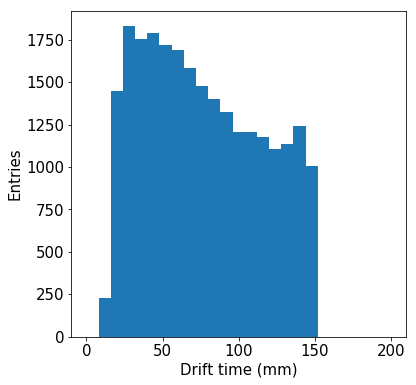

In [208]:
hist(s2eq2p0zlt15.Z, 25, (0,200))
labels("Drift time (mm)", "Entries")

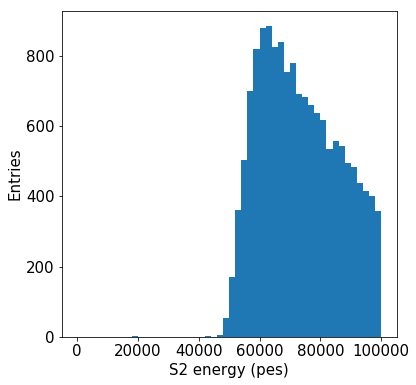

In [209]:
hist(s2eq2p0zlt15.S2e, 50, (0e3,1e5))
labels("S2 energy (pes)", "Entries")

In [210]:
s2eq2p0zgt15 = s2eq2p0[s2eq2p0.Z > 150]
s2eq2p0zgt15.head()

,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
85,93,1.491674e+09,0,2,200.0,28.307272,147.862793,486400.0,20.106250,7214.650391,...,655787.5,26.0,169.3875,169.3875,103.295794,10.551315,103.833286,0.101794,11.349135,10.087339
164,172,1.491674e+09,0,2,225.0,35.584572,194.989060,494925.0,23.228625,10212.998047,...,666387.5,25.0,171.4625,171.4625,111.392529,-1.561614,111.403475,-0.014018,10.478048,10.062891
206,221,1.491674e+09,0,2,275.0,60.577595,330.010369,498150.0,38.537875,13924.917969,...,680212.5,59.0,182.0625,182.0625,-67.353296,46.655495,81.934131,2.535784,13.466370,25.854156
250,262,1.491674e+09,0,2,300.0,66.006844,354.801630,486975.0,31.055250,11270.046875,...,662812.5,54.0,175.8375,175.8375,133.694952,32.438592,137.573989,0.238032,21.152187,20.632978
279,291,1.491674e+09,0,2,225.0,37.019848,208.834401,494925.0,46.741687,9357.777344,...,657962.5,31.0,163.0375,163.0375,-43.997267,23.697887,49.973486,2.647527,18.834596,10.455274


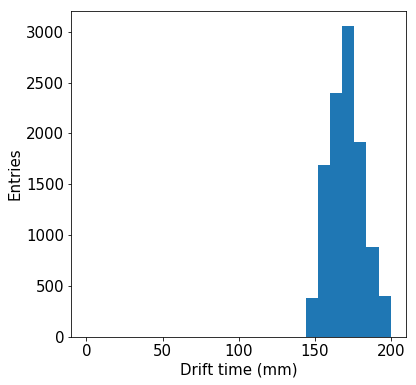

In [211]:
hist(s2eq2p0zgt15.Z, 25, (0,200))
labels("Drift time (mm)", "Entries")

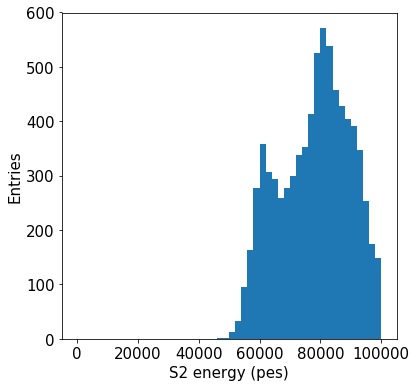

In [212]:
hist(s2eq2p0zgt15.S2e, 50, (0e3,1e5))
labels("S2 energy (pes)", "Entries")

In [213]:
s2eq2p1 = s2eq2[s2eq2.peak ==1]
s2eq2p0.head()

,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
3,5,1.491674e+09,0,2,225.0,54.494896,286.139376,615225.0,45.152500,10520.092773,...,672387.5,54.0,57.1625,57.1625,-21.676225,165.445635,166.859572,1.701072,15.885687,18.841620
18,20,1.491674e+09,0,2,225.0,37.718376,217.355925,530875.0,36.222500,11878.065430,...,655912.5,59.0,125.0375,125.0375,48.661950,-86.593677,99.330007,-1.058819,27.819668,13.258652
32,38,1.491674e+09,0,2,150.0,14.287548,67.987579,606650.0,11.080000,12572.112305,...,657387.5,18.0,50.7375,50.7375,22.448518,-94.719632,97.343437,-1.338090,8.182807,8.481033
36,41,1.491674e+09,0,2,250.0,35.366230,188.548965,554525.0,16.371625,19231.455078,...,657187.5,41.0,102.6625,102.6625,-117.055839,-13.136582,117.790659,-3.029835,13.710427,11.128306
45,51,1.491674e+09,0,2,150.0,13.202993,63.658347,617375.0,11.054375,19796.833984,...,656437.5,23.0,39.0625,39.0625,-64.979138,-113.096915,130.434660,-2.092288,8.982178,9.346743


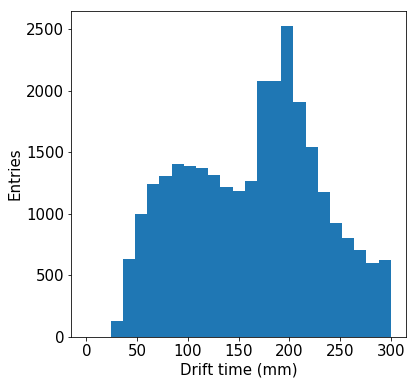

In [214]:
hist(s2eq2p1.Z, 25, (0,300))
labels("Drift time (mm)", "Entries")

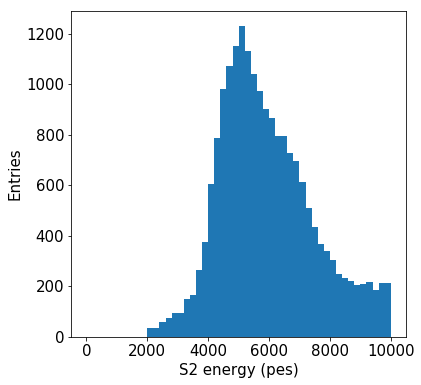

In [217]:
hist(s2eq2p1.S2e, 50, (0e3,1e4))
labels("S2 energy (pes)", "Entries")

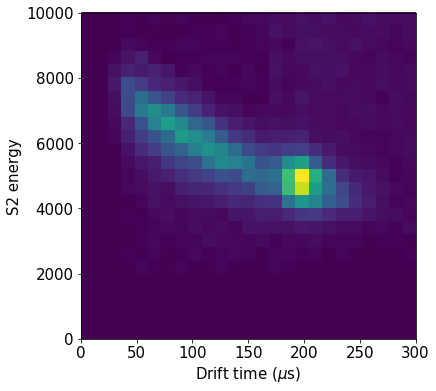

In [220]:
zrange =   0, 300
Erange = 0e3, 1e4
hist2d(s2eq2p1.Z, s2eq2p1.S2e, (25, 25), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")

In [196]:
XR1 = full[full.S2e > 2e3]
XR = XR1[XR1.S2e < 10e3]
print("Ratio:", len(XR)/len(full))
XR.head()

Ratio: 0.07008368508522936


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
33,38,1.491674e+09,1,2,150.0,14.287548,67.987579,606650.0,11.124375,547.778259,...,783687.5,1.0,177.0375,177.0375,-205.000000,-15.000000,205.548048,-3.068552,0.000000,0.000000
46,51,1.491674e+09,1,2,150.0,13.202993,63.658347,617375.0,5.129375,2506.131836,...,677912.5,4.0,60.5375,60.5375,-124.605900,-57.050477,137.045202,-2.712232,5.692910,4.045706
86,93,1.491674e+09,1,2,200.0,28.307272,147.862793,486400.0,9.578125,1025.614380,...,685712.5,3.0,199.3125,199.3125,58.267121,1.695648,58.291789,0.029093,4.714833,4.728493
91,97,1.491674e+09,1,2,225.0,20.952307,118.988705,630650.0,6.681750,1108.163086,...,779612.5,3.0,148.9625,148.9625,-162.021790,11.116134,162.402675,3.073091,4.592621,4.894740
100,105,1.491674e+09,1,2,250.0,14.728755,94.211445,589900.0,7.932688,1015.946838,...,751912.5,2.0,162.0125,162.0125,129.983840,45.000000,137.552894,0.333283,5.036084,0.000000


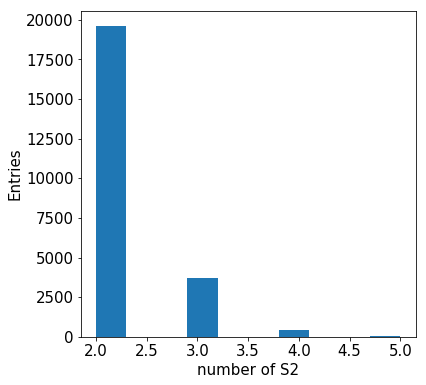

In [198]:
hist(XR.nS2)
labels("number of S2", "Entries")

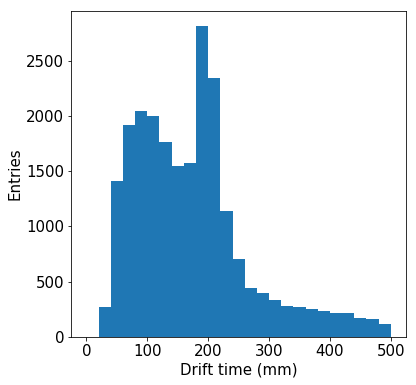

In [197]:
hist(XR.Z, 25, (0,500))
labels("Drift time (mm)", "Entries")

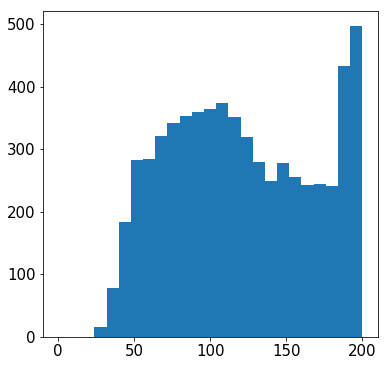

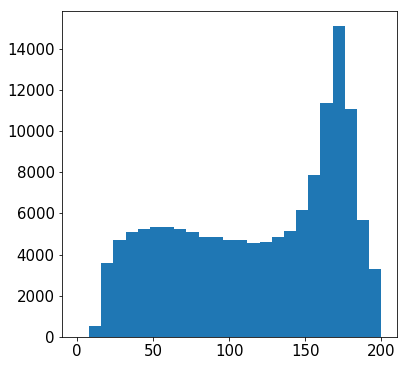

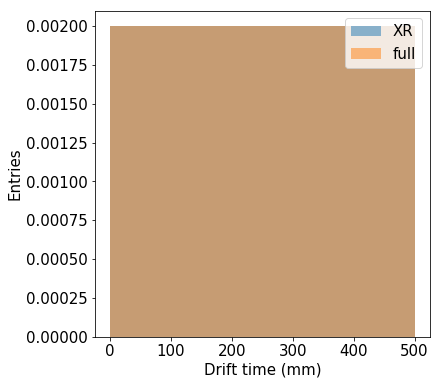

In [129]:
hist(XR.Z, 25, (0,200))
hist(full.Z, 25, (0,200))
doublehist(XR.Z, full.Z, ['XR','full'],(0,500))
labels("Drift time (mm)", "Entries")

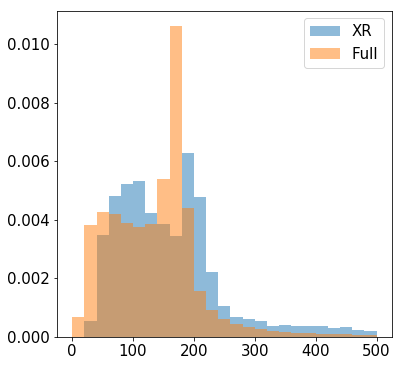

In [128]:
plt.figure()
h1 = plt.hist(XR.Z, 25, (0,500), label='XR', alpha=0.5, normed=True)
h2 = plt.hist(full.Z, 25,(0,500), label='Full', alpha=0.5, normed=True)
plt.legend()

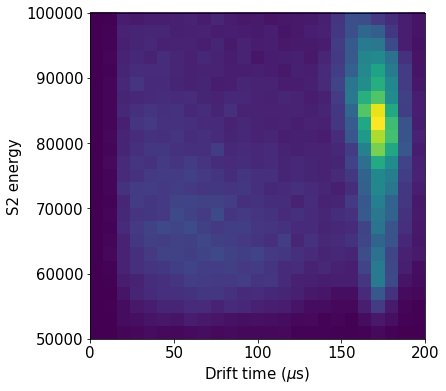

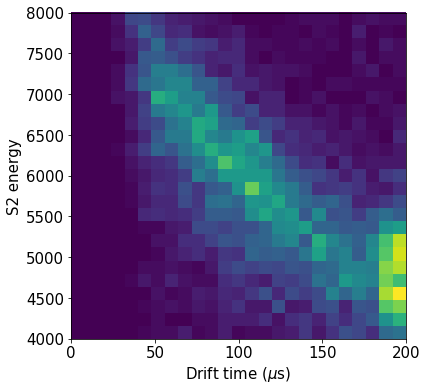

In [131]:
zrange =   0, 200
Erange = 50e3, 1e5
hist2d(full.Z, full.S2e, (25, 25), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")


Erange =  4e3, 8e3
hist2d(XR.Z, XR.S2e, (25, 25), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")

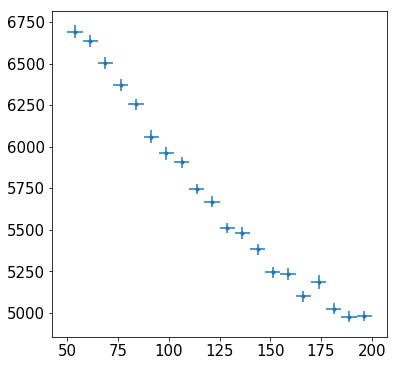

In [146]:
x, xe, y, ye  = plot_profile_histogram(XR.Z.values, 
                                       XR.S2e.values, 
                                       xr = (50,200), nbins=20)

In [152]:
len(ye)

20

fit values: E0 = 7750.704002491254 lifetime = -386.1549083415301
errors: E0 = 52.614758232506446 lifetime = 9.891721330180124
chi2 = 0.21503919922680823


/Users/jjgomezcadenas/miniconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 20 but corresponding boolean dimension is 12
  from ipykernel import kernelapp as app


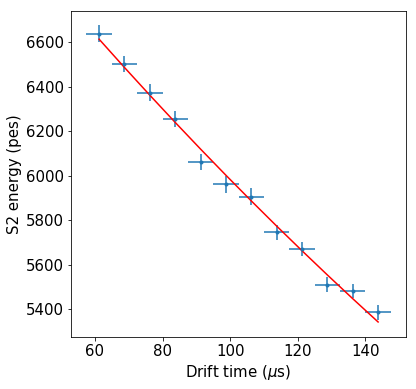

In [153]:
sel  = fitf.in_range(x, 60, 150)
x, y, ye = x[sel], y[sel], ye[sel]

f = fitf.fit(fitf.expo, x, y, (1e4, -200))
plt.errorbar(x=x, xerr=xe, y=y, yerr=ye,
                 linestyle='none', marker='.')
plt.plot(x, f.fn(x), fitOpt)
print('fit values: E0 = {} lifetime = {}'.format(f.values[0],f.values[1]))
print('errors: E0 = {} lifetime = {}'.format(f.errors[0],f.errors[1]))
print('chi2 = {}'.format(f.chi2))
labels("Drift time ($\mu$s)", "S2 energy (pes)")

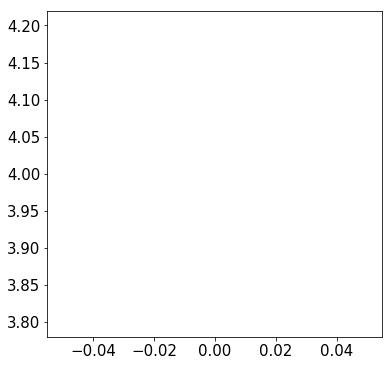

In [144]:
plt.plot(ze)

ValueError: err must be [ scalar | N, Nx1 or 2xN array-like ]

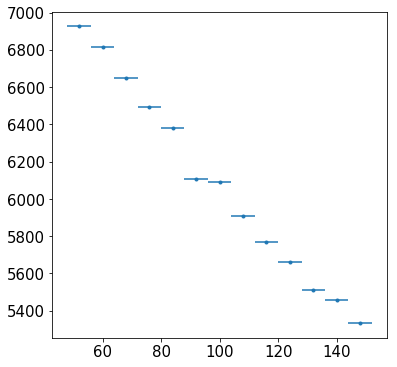

In [139]:
plt.errorbar(x=z, xerr=ze, y=E, yerr=Ee,
                 linestyle='none', marker='.')

plt.plot(z, f.fn(z), fitOpt)
print('fit values: E0 = {} lifetime = {}'.format(f.values[0],f.values[1]))
print('errors: E0 = {} lifetime = {}'.format(f.errors[0],f.errors[1]))
print('chi2 = {}'.format(f.chi2))
labels("Drift time ($\mu$s)", "S2 energy (pes)")



#### NB very visible position of the source

### Raw S2

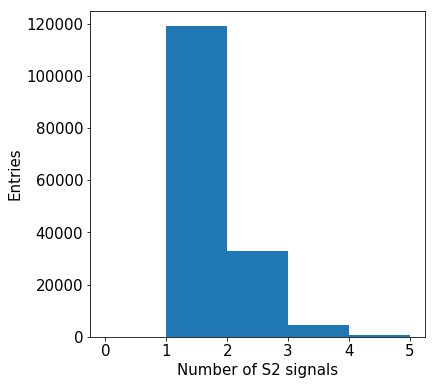

In [12]:
hist(full.nS2, 5, (0,5))
labels("Number of S2 signals", "Entries")

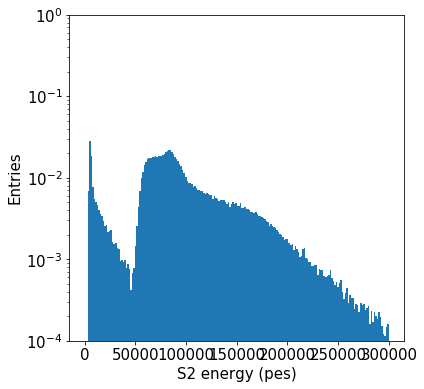

In [13]:
pdf(full.S2e, 200, (0,3e5))
labels("S2 energy (pes)", "Entries")

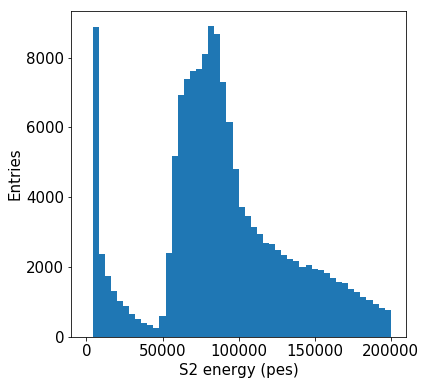

In [16]:
hist(full.S2e, 50, (0e3,2e5))
labels("S2 energy (pes)", "Entries")

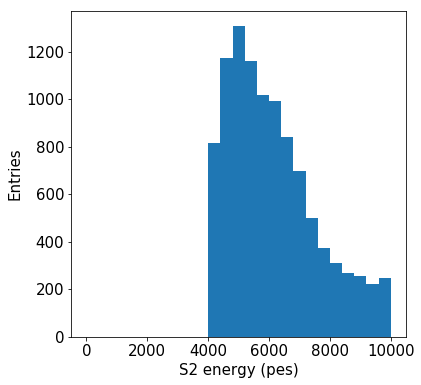

In [17]:
n, bins, patches  = hist(full.S2e, 25, (0,1e4))
labels("S2 energy (pes)", "Entries")

### S1

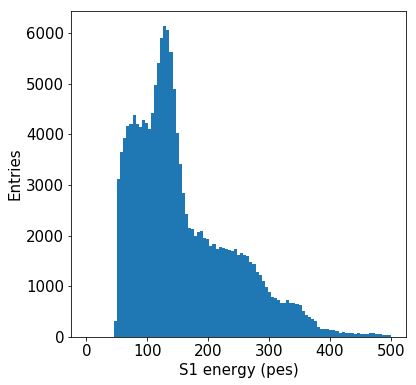

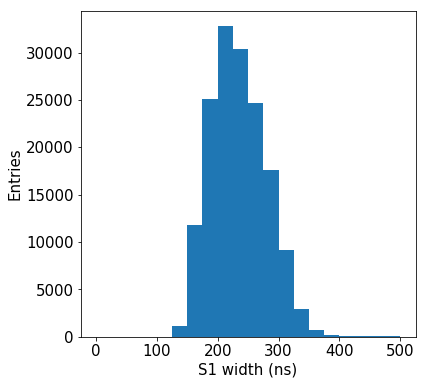

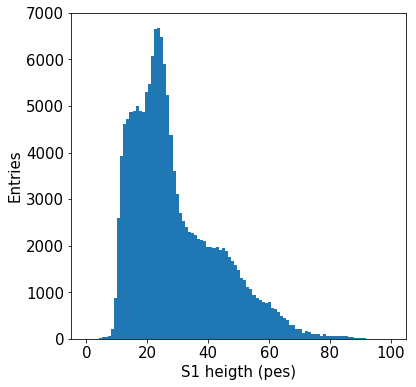

In [18]:
bins = np.linspace(0, 500, 100)
n, bins, patches  = hist(full.S1e, bins)
labels("S1 energy (pes)", "Entries")

bins = np.linspace(0, 500, 21)
n, bins, patches  = hist(full.S1w, bins)
labels("S1 width (ns)", "Entries")

bins = np.linspace(0, 100, 100)
n, bins, patches  =  hist(full.S1h, bins)
labels("S1 heigth (pes)", "Entries")

### S2 energy vs Z

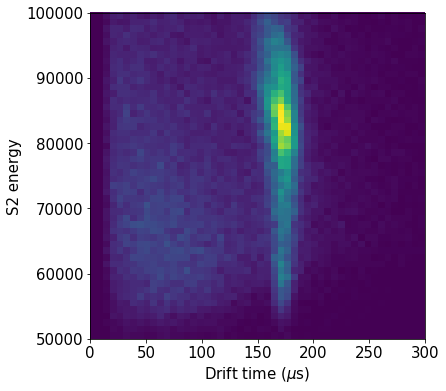

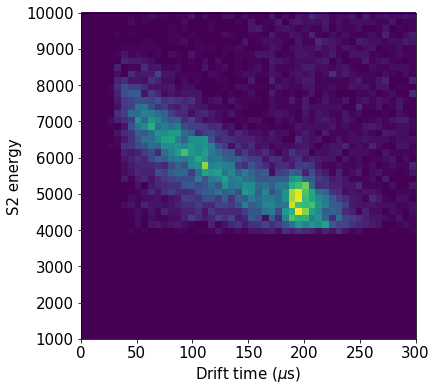

In [20]:
zrange =   0, 300
Erange = 50e3, 1e5
hist2d(full.Z, full.S2e, (50, 50), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")


Erange =  1e3, 1e4
hist2d(full.Z, full.S2e, (50, 50), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")

### S1 energy vs Z

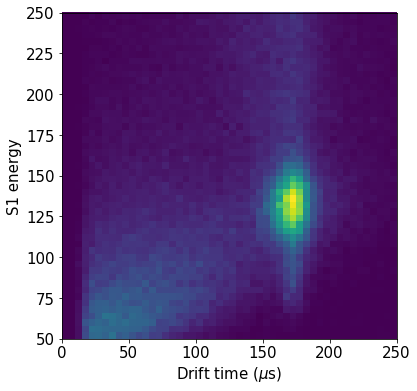

In [22]:
zrange =   0, 250
Erange = 50, 250
hist2d(full.Z, full.S1e, (50, 50), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S1 energy")

### S1 vs S2

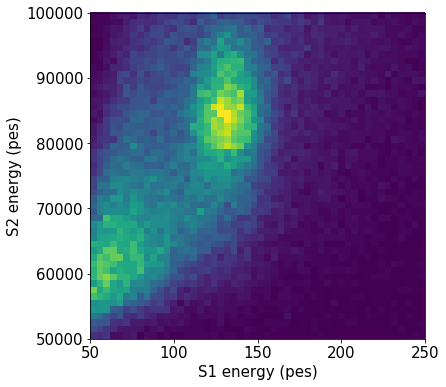

In [23]:
zrange =   0, 250
S1range = 50, 250
S2range = 50e3, 1e5
hist2d(full.S1e, full.S2e, (50, 50), range=(S1range, S2range))
labels("S1 energy (pes)", "S2 energy (pes)")
#save("S1_energy_vs_S2_energy_short")

In [31]:
s1pe_l = full[full.S1e > 120]
s1pe   = s1pe_l[s1pe_l.S1e < 150]
print("Ratio:", len(s1pe)/len(full))
s1pe.head()

Ratio: 0.20979337420810443


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
1,2,1.491674e+09,0,1,200.0,24.205078,129.749825,557000.0,38.343750,10287.787109,...,653687.5,25.0,96.6875,96.6875,136.927309,5.200002,137.026012,0.037958,9.209800,10.444016
13,15,1.491674e+09,0,1,200.0,23.228331,125.666456,589000.0,36.438938,6649.191406,...,653187.5,20.0,64.1875,64.1875,-178.994732,13.991681,179.540751,3.063583,8.998335,8.417012
16,18,1.491674e+09,0,1,200.0,26.175219,133.905174,492500.0,21.042875,8758.824219,...,660787.5,25.0,168.2875,168.2875,-68.850136,-6.777933,69.182957,-3.043464,10.565948,10.399427
27,31,1.491674e+09,0,1,250.0,22.075649,124.195831,506900.0,26.102625,9916.955078,...,656262.5,21.0,149.3625,149.3625,75.048811,4.260599,75.169653,0.056710,9.542632,9.141571
28,32,1.491674e+09,0,1,250.0,22.347191,125.900764,481525.0,28.441813,7106.282715,...,662237.5,23.0,180.7125,180.7125,57.551416,14.633531,59.382705,0.248992,9.154001,11.972889


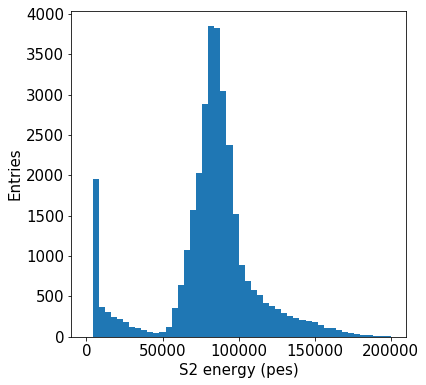

In [32]:
hist(s1pe.S2e, 50, (0e3,2e5))
labels("S2 energy (pes)", "Entries")

In [33]:
s1npe = full[full.S1e < 100]
print("Ratio:", len(s1npe)/len(full))
s1npe.head()

Ratio: 0.25369338822959553


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
9,11,1.491674e+09,0,1,250.0,13.720692,90.543010,590350.0,19.764563,7944.929199,...,666012.5,20.0,75.6625,75.6625,-63.069691,-2.985949,63.140335,-3.094284,8.536955,8.548020
10,12,1.491674e+09,0,1,175.0,13.480074,72.238658,559650.0,13.106063,13720.609375,...,655787.5,29.0,96.1375,96.1375,-97.459859,-13.289184,98.361713,-3.006073,10.916775,10.313899
12,14,1.491674e+09,0,1,150.0,11.884805,55.847104,562375.0,9.837500,16129.740234,...,654187.5,21.0,91.8125,91.8125,23.050012,-1.417713,23.093569,-0.061429,8.671671,9.331864
22,26,1.491674e+09,0,1,150.0,14.157608,65.870162,621825.0,21.499125,10903.039062,...,661862.5,25.0,40.0375,40.0375,-9.935620,-135.231888,135.596387,-1.644136,9.624949,9.062485
23,27,1.491674e+09,0,1,175.0,13.342910,72.002379,528725.0,14.914750,11069.202148,...,660362.5,28.0,131.6375,131.6375,-0.775013,80.110136,80.113885,1.580470,10.674988,11.675440


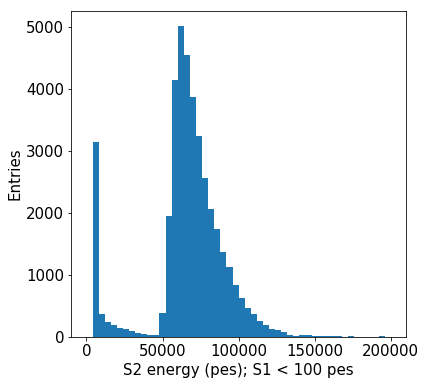

In [34]:
hist(s1npe.S2e, 50, (0e3,2e5))
labels("S2 energy (pes); S1 < 100 pes", "Entries")

## Short drift time: Z < 250 $\mu$s

In [94]:
shortZ = full[full.Z < 250]
fidz = shortZ[shortZ.Z > 50]
print("Ratio:", len(fidz)/len(full))
fidz.head()

Ratio: 0.8121438859925304


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,1,1.491674e+09,0,1,275.0,49.620018,287.162550,537150.0,40.100437,13367.398438,...,657112.5,54.0,119.9625,119.9625,97.811136,40.847802,105.997930,0.395602,25.243436,11.175782
1,2,1.491674e+09,0,1,200.0,24.205078,129.749825,557000.0,38.343750,10287.787109,...,653687.5,25.0,96.6875,96.6875,136.927309,5.200002,137.026012,0.037958,9.209800,10.444016
2,4,1.491674e+09,0,1,225.0,30.098822,160.997304,470600.0,23.514125,8284.446289,...,664512.5,19.0,193.9125,193.9125,-55.612291,-10.052078,56.513460,-2.962771,10.149977,8.824298
3,5,1.491674e+09,0,2,225.0,54.494896,286.139376,615225.0,45.152500,10520.092773,...,672387.5,54.0,57.1625,57.1625,-21.676225,165.445635,166.859572,1.701072,15.885687,18.841620
5,7,1.491674e+09,0,1,275.0,43.927078,260.479945,492225.0,30.144562,10780.770508,...,667762.5,45.0,175.5375,175.5375,189.175990,11.603022,189.531489,0.061258,15.089571,11.957589


# S2 energy

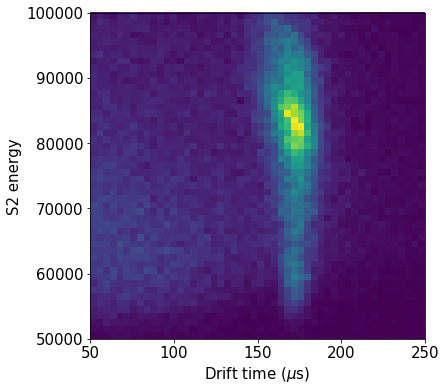

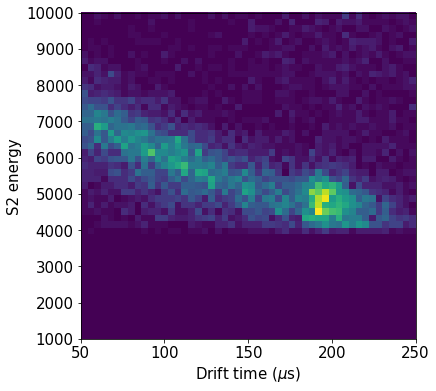

In [95]:
zrange =   50, 250
Erange = 50e3, 1e5
hist2d(shortZ.Z, shortZ.S2e, (50, 50), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")


Erange =  1e3, 1e4
hist2d(shortZ.Z, shortZ.S2e, (50, 50), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")

### X rays

In [96]:
XR1 = fidz[fidz.S2e > 4e3]
XR = XR1[XR1.S2e < 8e3]
print("Ratio:", len(XR)/len(full))
XR.head()

Ratio: 0.04641750901836815


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
45,51,1.491674e+09,1,2,150.0,13.202993,63.658347,617375.0,5.129375,2506.131836,...,677912.5,4.0,60.5375,60.5375,-124.605900,-57.050477,137.045202,-2.712232,5.692910,4.045706
85,93,1.491674e+09,1,2,200.0,28.307272,147.862793,486400.0,9.578125,1025.614380,...,685712.5,3.0,199.3125,199.3125,58.267121,1.695648,58.291789,0.029093,4.714833,4.728493
90,97,1.491674e+09,1,2,225.0,20.952307,118.988705,630650.0,6.681750,1108.163086,...,779612.5,3.0,148.9625,148.9625,-162.021790,11.116134,162.402675,3.073091,4.592621,4.894740
99,105,1.491674e+09,1,2,250.0,14.728755,94.211445,589900.0,7.932688,1015.946838,...,751912.5,2.0,162.0125,162.0125,129.983840,45.000000,137.552894,0.333283,5.036084,0.000000
101,106,1.491674e+09,1,3,175.0,21.764864,106.785119,625325.0,7.712500,1168.938965,...,777112.5,2.0,151.7875,151.7875,-75.000000,29.147127,80.464620,2.770928,0.000000,4.960763


### Geometry

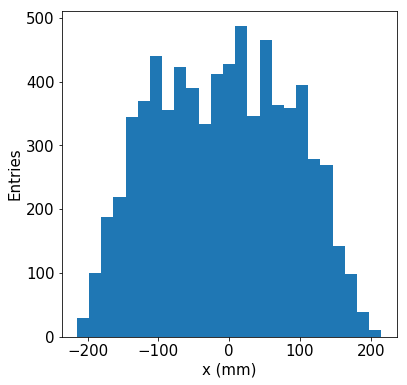

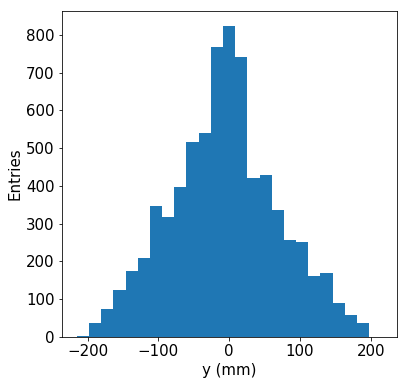

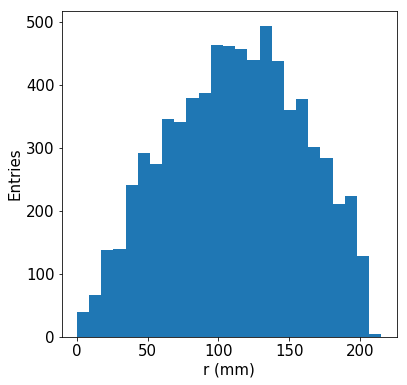

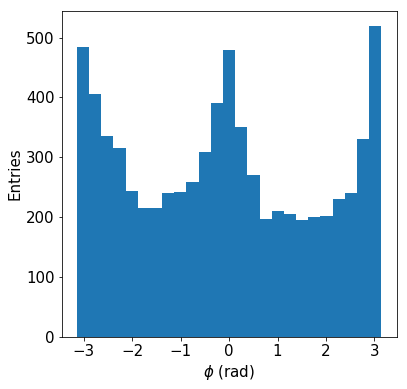

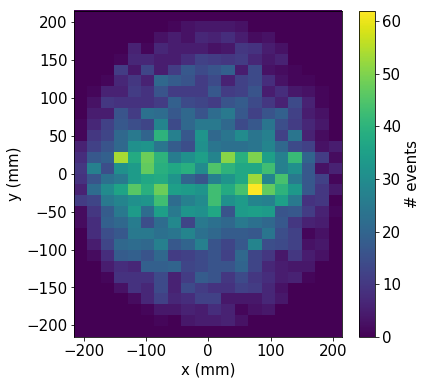

In [97]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi

hist(XR.X, 25, range=xrange)
labels("x (mm)", "Entries")


hist(XR.Y, 25, range=yrange)
labels("y (mm)", "Entries")

hist(XR.R, 25, range=rrange)
labels("r (mm)", "Entries")

hist(XR.Phi, 25, range=prange)
labels("$\phi$ (rad)", "Entries")

nevts, xs, ys, _ = \
hist2d(XR.X, XR.Y, (20, 30), range=(xrange, yrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)")


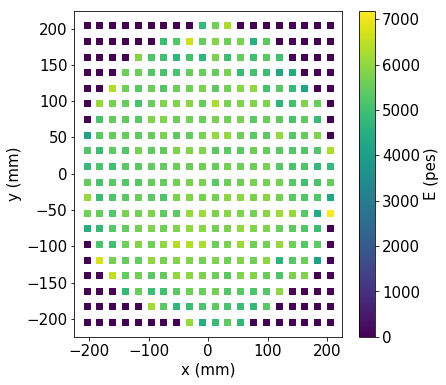

In [98]:

pf, _, cb = profile_and_scatter(XR.X, XR.Y, XR.S2e, (20, 20), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")

In [99]:
rfid = 180
XRfid = XR[XR.R < rfid]
print("Ratio:", len(XRfid)/len(full))
print("Ratio:", len(XRfid)/len(XR))
XRfid.head()

Ratio: 0.04270181387107876
Ratio: 0.919950569820129


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
45,51,1.491674e+09,1,2,150.0,13.202993,63.658347,617375.0,5.129375,2506.131836,...,677912.5,4.0,60.5375,60.5375,-124.605900,-57.050477,137.045202,-2.712232,5.692910,4.045706
85,93,1.491674e+09,1,2,200.0,28.307272,147.862793,486400.0,9.578125,1025.614380,...,685712.5,3.0,199.3125,199.3125,58.267121,1.695648,58.291789,0.029093,4.714833,4.728493
90,97,1.491674e+09,1,2,225.0,20.952307,118.988705,630650.0,6.681750,1108.163086,...,779612.5,3.0,148.9625,148.9625,-162.021790,11.116134,162.402675,3.073091,4.592621,4.894740
99,105,1.491674e+09,1,2,250.0,14.728755,94.211445,589900.0,7.932688,1015.946838,...,751912.5,2.0,162.0125,162.0125,129.983840,45.000000,137.552894,0.333283,5.036084,0.000000
101,106,1.491674e+09,1,3,175.0,21.764864,106.785119,625325.0,7.712500,1168.938965,...,777112.5,2.0,151.7875,151.7875,-75.000000,29.147127,80.464620,2.770928,0.000000,4.960763


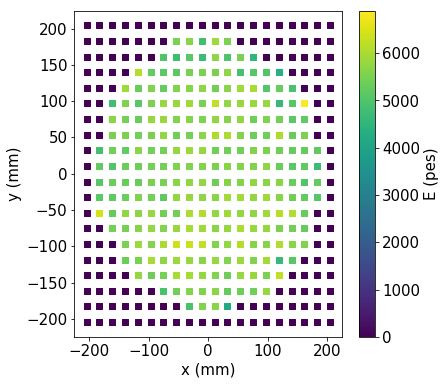

In [100]:
pf, _, cb = profile_and_scatter(XRfid.X, XRfid.Y, XRfid.S2e, (20, 20), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")

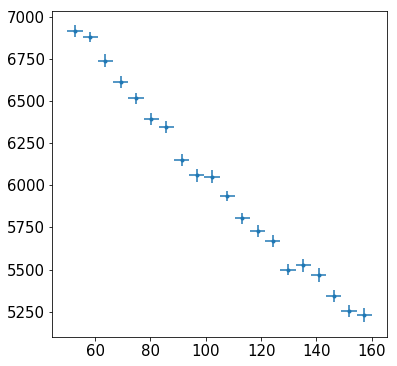

In [102]:
x, xe, y, ye  = plot_profile_histogram(XRfid.Z.values, 
                                           XRfid.S2e.values, 
                                           xr = (50,160), nbins=20)

fit values: E0 = 8021.503918903966 lifetime = -357.94241013055915
errors: E0 = 41.68392356271266 lifetime = 6.385806299117584
chi2 = 0.3041118878281418


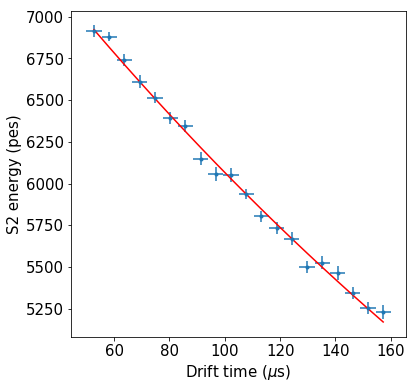

In [103]:
sel  = fitf.in_range(x, 50, 160)
x, y = x[sel], y[sel]

f = fitf.fit(fitf.expo, x, y, (1e4, -200))
plt.errorbar(x=x, xerr=xe, y=y, yerr=ye,
                 linestyle='none', marker='.')
plt.plot(x, f.fn(x), fitOpt)
print('fit values: E0 = {} lifetime = {}'.format(f.values[0],f.values[1]))
print('errors: E0 = {} lifetime = {}'.format(f.errors[0],f.errors[1]))
print('chi2 = {}'.format(f.chi2))
labels("Drift time ($\mu$s)", "S2 energy (pes)")

In [104]:
#('FitFunction'    , 'fn values errors chi2')):

In [105]:
zfun  = f.fn
zmin  = np.min(x)
zcorr = lambda z: zfun(zmin)/zfun(z)

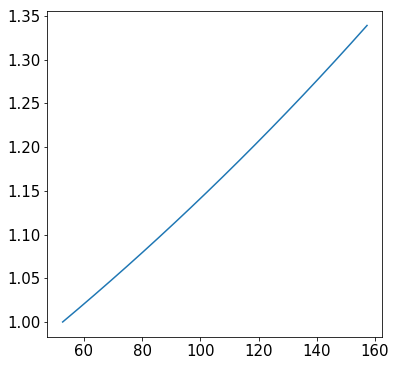

In [106]:
plt.plot(x, zcorr(x))

### Correction by attachment

### Z corr in fiducial (no hard cut on R)

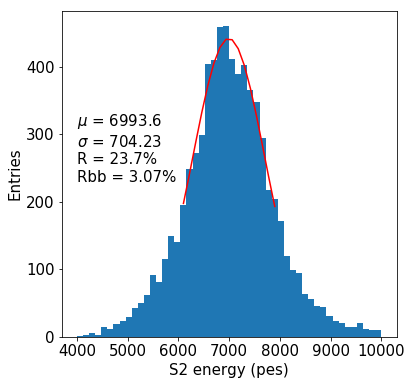

In [107]:
Erange = 4e3, 10e3
E = XR.S2e * zcorr(XR.Z)
y, x, _ = hist(E, 50, range=Erange)
x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 6000, 8000)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 8e3, 200))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f))
labels("S2 energy (pes)", "Entries")

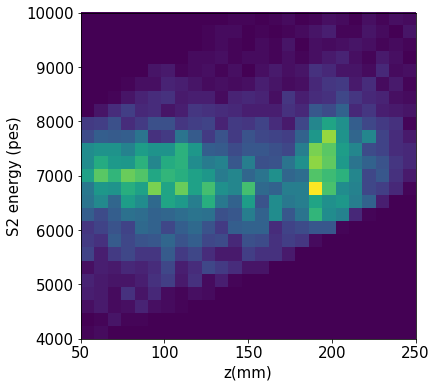

In [108]:
hist2d(XR.Z, E, (25, 25), range=(zrange, Erange))
labels("z(mm)", "S2 energy (pes)")

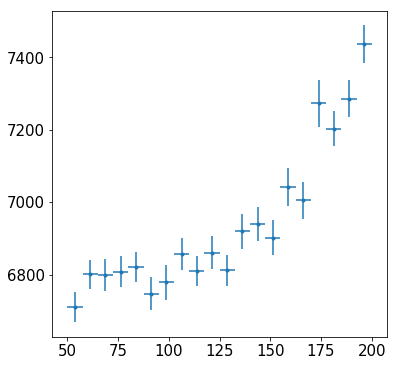

In [109]:
Erange = 4e3, 8e3
E = XR.S2e * zcorr(XR.Z)
x, xe, y, ye  = plot_profile_histogram(XR.Z.values, 
                                           E, 
                                           xr = (50,200), nbins=20)

### Z corr in restricted fiducial (hard cut on R)

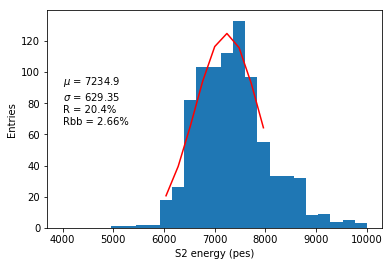

In [129]:
Erange = 4e3, 10e3
E = fidzr.S2e * zcorr(fidzr.Z)
y, x, _ = hist(E, 25, range=Erange)
x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 6000, 8000)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 8e3, 200))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f))
labels("S2 energy (pes)", "Entries")

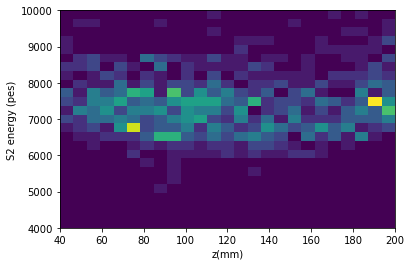

In [130]:
hist2d(fidzr.Z, E, (25, 25), range=(zrange, Erange))
labels("z(mm)", "S2 energy (pes)")

### Tracking plane

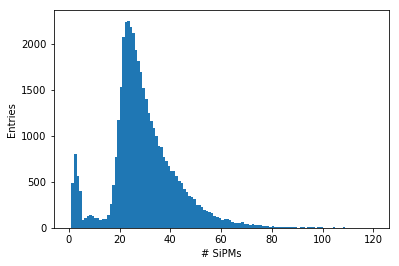

In [131]:
nrange = 0, 120

hist(fidz.Nsipm, max(nrange), nrange)
labels("# SiPMs", "Entries")

### Event distribution 

#### all events

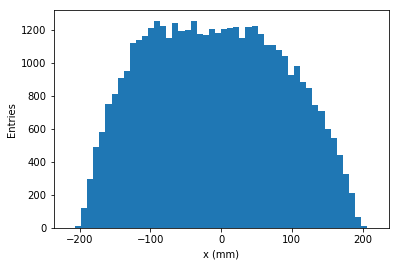

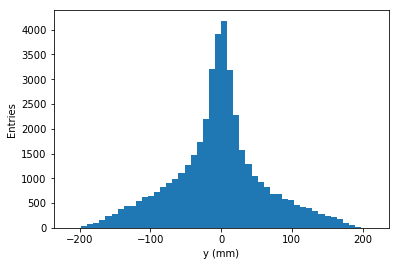

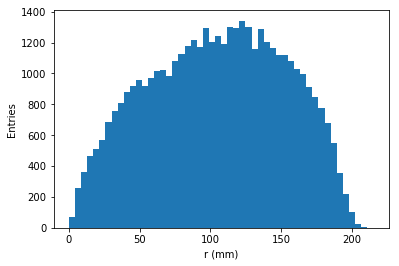

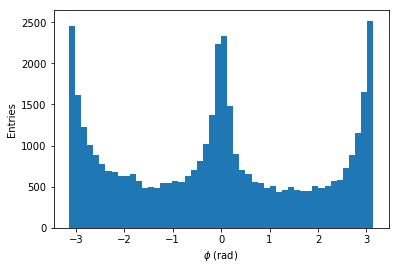

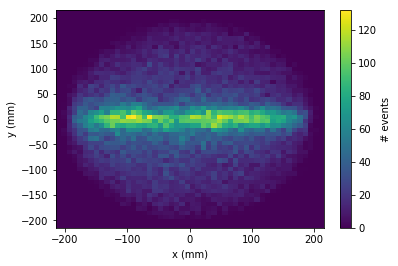

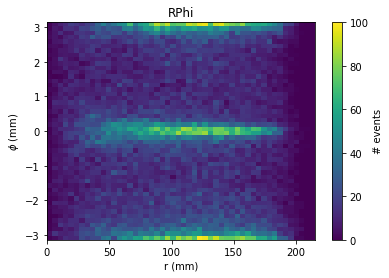

In [135]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi

hist(fidz.X, 50, range=xrange)
labels("x (mm)", "Entries")

hist(fidz.Y, 50, range=yrange)
labels("y (mm)", "Entries")

hist(fidz.R, 50, range=rrange)
labels("r (mm)", "Entries")

hist(fidz.Phi, 50, range=prange)
labels("$\phi$ (rad)", "Entries")


nevts, xs, ys, _ = \
hist2d(fidz.X, fidz.Y, (50, 50), range=(xrange, yrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)")

################################
hist2d(fidz.R, fidz.Phi, (50, 50), range=(rrange, prange))
plt.colorbar().set_label("# events")
labels("r (mm)", "$\phi$ (mm)")
save("RPhi")


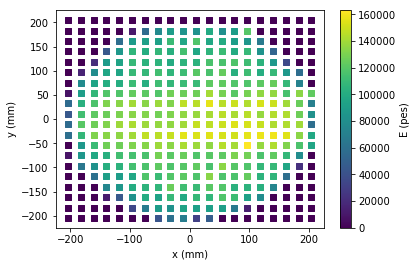

In [166]:
Erange =  4e3, 200e3

E = fidz.S2e * zcorr(fidz.Z)

pf, _, cb = profile_and_scatter(fidz.X, fidz.Y, E, (20, 20), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")

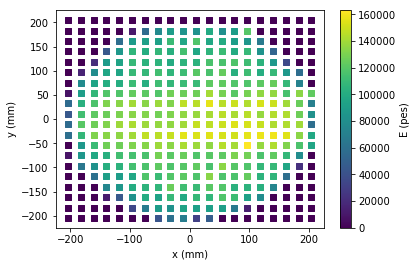

In [167]:
Erange =  4e3, 10e3

E = fidz.S2e * zcorr(fidz.Z)

pf, _, cb = profile_and_scatter(fidz.X, fidz.Y, E, (20, 20), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")

### Cut on R

In [172]:
rfid = 180
fidr = fidz[fidz.R < rfid]
print("Ratio:", len(fidr)/len(full))
fidr.head()

Ratio: 0.7681528422164384


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
1,22143,1.491517e+09,0,2,175.0,14.436388,73.639985,570075.0,16.071250,8490.367188,...,659187.5,19.0,89.1125,89.1125,-97.569578,22.380145,100.103414,2.916117,8.997476,9.208689
2,22143,1.491517e+09,1,2,175.0,14.436388,73.639985,570075.0,7.319375,1538.694702,...,676287.5,2.0,106.2125,106.2125,-119.837734,25.000000,122.417656,2.935927,5.021407,0.000000
3,22144,1.491517e+09,0,2,300.0,25.215143,152.466999,565475.0,19.281437,13409.538086,...,655262.5,30.0,89.7875,89.7875,54.959338,-26.589229,61.053386,-0.450602,10.232118,10.337627
4,22144,1.491517e+09,1,2,300.0,25.215143,152.466999,565475.0,8.328125,4597.053711,...,681487.5,8.0,116.0125,116.0125,36.625278,13.021865,38.871326,0.341604,6.569558,6.368801
6,22145,1.491517e+09,1,2,225.0,18.023479,106.346495,627450.0,11.661062,3512.965332,...,826112.5,7.0,198.6625,198.6625,-23.618646,14.776077,27.859880,2.582554,6.612139,6.336431


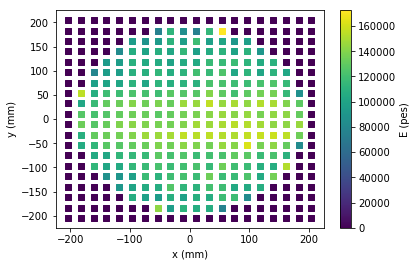

In [173]:
Erange =  4e3, 200e3

E = fidr.S2e * zcorr(fidr.Z)

pf, _, cb = profile_and_scatter(fidr.X, fidr.Y, E, (20, 20), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")

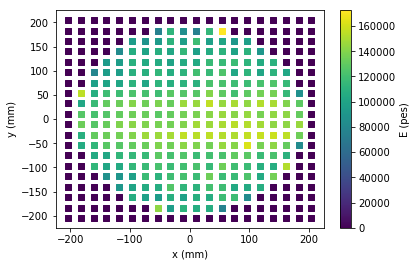

In [174]:
Erange =  60e3, 90e3

E = fidr.S2e * zcorr(fidr.Z)

pf, _, cb = profile_and_scatter(fidr.X, fidr.Y, E, (20, 20), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")

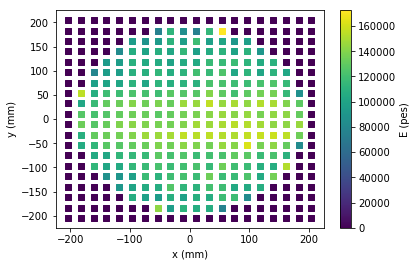

In [175]:
Erange =  4e3, 10e3

E = fidr.S2e * zcorr(fidr.Z)

pf, _, cb = profile_and_scatter(fidr.X, fidr.Y, E, (20, 20), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")

#### X rays

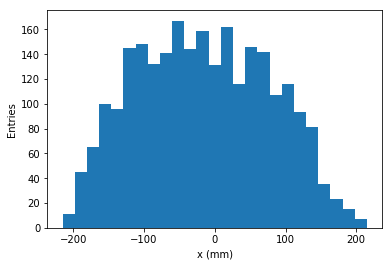

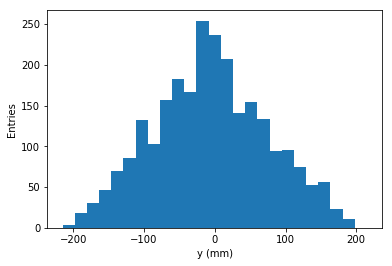

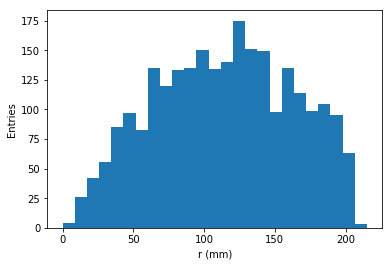

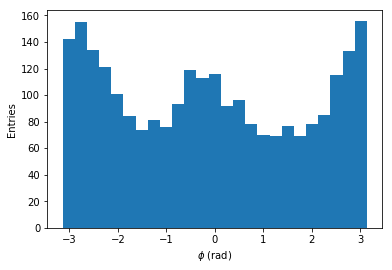

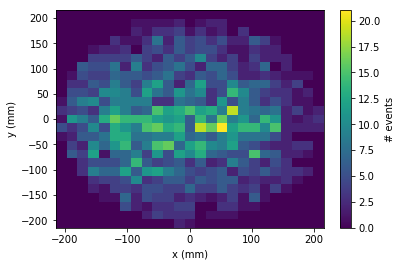

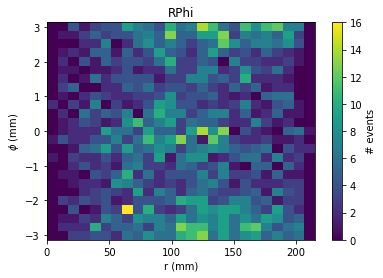

In [137]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi

hist(XR.X, 25, range=xrange)
labels("x (mm)", "Entries")

hist(XR.Y, 25, range=yrange)
labels("y (mm)", "Entries")

hist(XR.R, 25, range=rrange)
labels("r (mm)", "Entries")

hist(XR.Phi, 25, range=prange)
labels("$\phi$ (rad)", "Entries")


nevts, xs, ys, _ = \
hist2d(XR.X, XR.Y, (25, 25), range=(xrange, yrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)")

################################
hist2d(XR.R, XR.Phi, (25, 25), range=(rrange, prange))
plt.colorbar().set_label("# events")
labels("r (mm)", "$\phi$ (mm)")
save("RPhi")

In [141]:
yfid = 50
fidy = fidz[abs(fidz.Y) < yfid]
print("Ratio:", len(fidy)/len(full))
fidy.head()

Ratio: 0.5075063181320961


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
1,22143,1.491517e+09,0,2,175.0,14.436388,73.639985,570075.0,16.071250,8490.367188,...,659187.5,19.0,89.1125,89.1125,-97.569578,22.380145,100.103414,2.916117,8.997476,9.208689
2,22143,1.491517e+09,1,2,175.0,14.436388,73.639985,570075.0,7.319375,1538.694702,...,676287.5,2.0,106.2125,106.2125,-119.837734,25.000000,122.417656,2.935927,5.021407,0.000000
3,22144,1.491517e+09,0,2,300.0,25.215143,152.466999,565475.0,19.281437,13409.538086,...,655262.5,30.0,89.7875,89.7875,54.959338,-26.589229,61.053386,-0.450602,10.232118,10.337627
4,22144,1.491517e+09,1,2,300.0,25.215143,152.466999,565475.0,8.328125,4597.053711,...,681487.5,8.0,116.0125,116.0125,36.625278,13.021865,38.871326,0.341604,6.569558,6.368801
6,22145,1.491517e+09,1,2,225.0,18.023479,106.346495,627450.0,11.661062,3512.965332,...,826112.5,7.0,198.6625,198.6625,-23.618646,14.776077,27.859880,2.582554,6.612139,6.336431


### After y fiducial cut

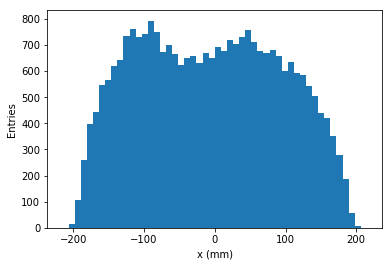

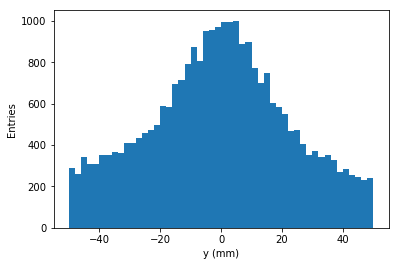

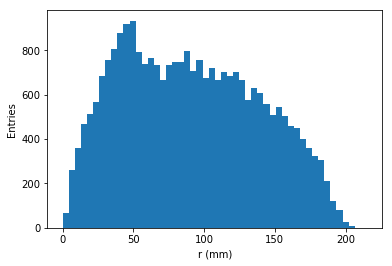

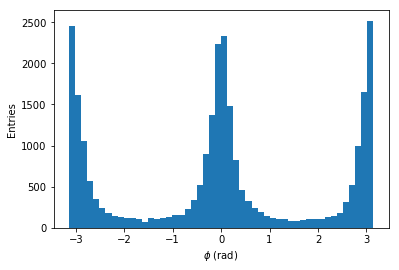

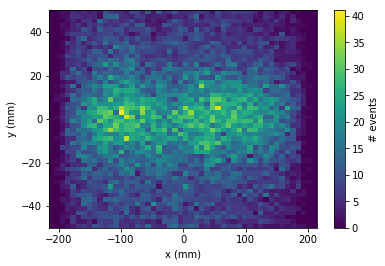

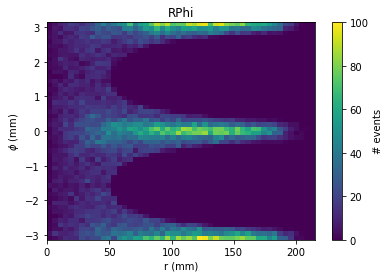

In [143]:
xrange = -215, 215
yrange = -50, 50
rrange =    0, 215
prange = - pi,  pi

hist(fidy.X, 50, range=xrange)
labels("x (mm)", "Entries")

hist(fidy.Y, 50, range=yrange)
labels("y (mm)", "Entries")

hist(fidy.R, 50, range=rrange)
labels("r (mm)", "Entries")

hist(fidy.Phi, 50, range=prange)
labels("$\phi$ (rad)", "Entries")


nevts, xs, ys, _ = \
hist2d(fidy.X, fidy.Y, (50, 50), range=(xrange, yrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)")

################################
hist2d(fidy.R, fidy.Phi, (50, 50), range=(rrange, prange))
plt.colorbar().set_label("# events")
labels("r (mm)", "$\phi$ (mm)")
save("RPhi")

### X Rays

In [147]:
XRyfid = 150
XRxfid = 150
fidyXR = XR[abs(XR.Y) < XRyfid]
fidXR = fidyXR[abs(fidyXR.X) < XRxfid]
print("Ratio:", len(fidXR)/len(full))
print("Ratio wr XR:", len(fidXR)/len(XR))
fidXR.head()

Ratio: 0.039606201199502096
Ratio wr XR: 0.8310249307479224


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
2,22143,1.491517e+09,1,2,175.0,14.436388,73.639985,570075.0,7.319375,1538.694702,...,676287.5,2.0,106.2125,106.2125,-119.837734,25.000000,122.417656,2.935927,5.021407,0.000000
54,22198,1.491517e+09,1,2,150.0,11.873551,59.949914,587200.0,6.821875,2016.625488,...,675637.5,3.0,88.4375,88.4375,-108.665341,-3.063693,108.708521,-3.113406,4.834143,3.964192
60,22207,1.491517e+09,1,2,225.0,28.579346,161.185127,521875.0,8.339313,1137.746338,...,688637.5,1.0,166.7625,166.7625,55.000000,25.000000,60.415230,0.426627,0.000000,0.000000
85,22238,1.491517e+09,1,2,250.0,21.733898,133.757807,578100.0,9.105875,1368.932739,...,730237.5,3.0,152.1375,152.1375,-52.123646,-27.632376,58.995107,-2.654132,4.544368,4.421186
126,22281,1.491517e+09,1,2,225.0,27.146255,142.006234,517700.0,10.355562,962.683411,...,712112.5,2.0,194.4125,194.4125,100.789301,-35.000000,106.693407,-0.334231,4.963114,0.000000


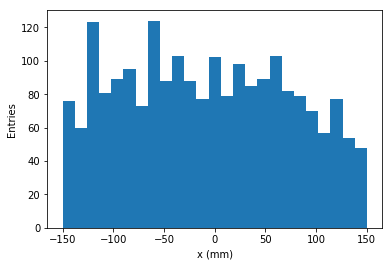

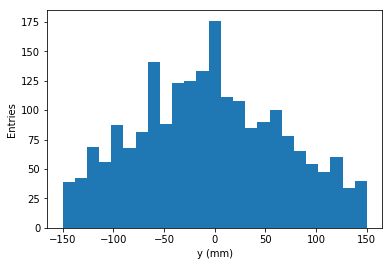

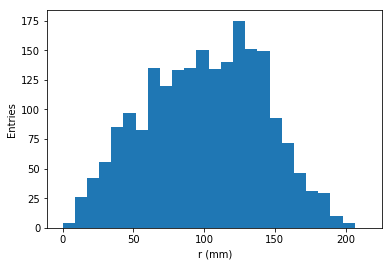

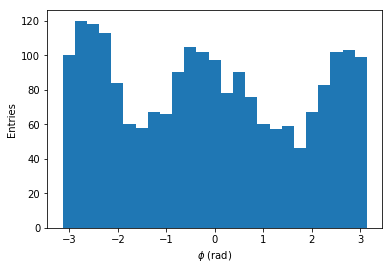

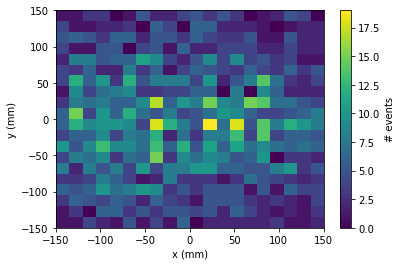

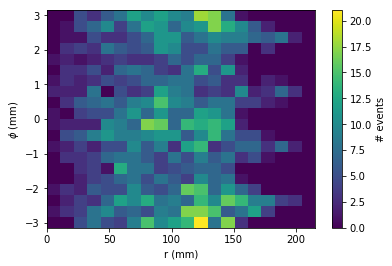

In [159]:
xrange = -150, 150
yrange = -150, 150
rrange =    0, 215
prange = - pi,  pi
bins = 25

hist(fidXR.X, bins, range=xrange)
labels("x (mm)", "Entries")

hist(fidXR.Y, bins, range=yrange)
labels("y (mm)", "Entries")

hist(fidXR.R, bins, range=rrange)
labels("r (mm)", "Entries")

hist(fidXR.Phi, bins, range=prange)
labels("$\phi$ (rad)", "Entries")


nevts, xs, ys, _ = \
hist2d(fidXR.X, fidXR.Y, (20, 20), range=(xrange, yrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)")

################################
hist2d(fidXR.R, fidXR.Phi, (20, 20), range=(rrange, prange))
plt.colorbar().set_label("# events")
labels("r (mm)", "$\phi$ (mm)")

### Energy vs XY

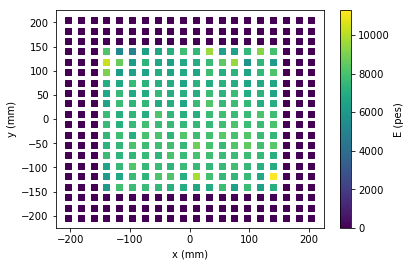

In [160]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi
Erange =  4e3, 9e3

E = fidXR.S2e * zcorr(fidXR.Z)

pf, _, cb = profile_and_scatter(fidXR.X, fidXR.Y, E, (20, 20), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")

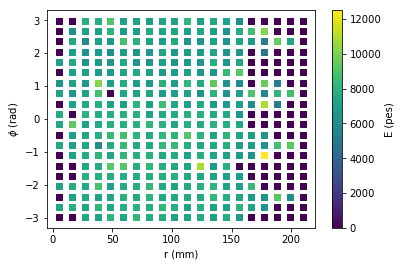

In [155]:
_, _, cb = profile_and_scatter(fidXR.R, fidXR.Phi, E, (20, 20), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")

In [156]:
XRrfid1 = 20
XRxfid2 = 160
fidyXR = XR[abs(XR.Y) < XRyfid]
fidXR = fidyXR[abs(fidyXR.X) < XRxfid]
fidr1XR = fidXR[abs(fidXR.R) > XRrfid1]
fidrXR = fidr1XR[abs(fidr1XR.R) < XRxfid2]
print("Ratio:", len(fidrXR)/len(full))
print("Ratio wr XR:", len(fidrXR)/len(XR))
fidrXR.head()

Ratio: 0.03621138395383049
Ratio wr XR: 0.7597942223981005


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
2,22143,1.491517e+09,1,2,175.0,14.436388,73.639985,570075.0,7.319375,1538.694702,...,676287.5,2.0,106.2125,106.2125,-119.837734,25.000000,122.417656,2.935927,5.021407,0.000000
54,22198,1.491517e+09,1,2,150.0,11.873551,59.949914,587200.0,6.821875,2016.625488,...,675637.5,3.0,88.4375,88.4375,-108.665341,-3.063693,108.708521,-3.113406,4.834143,3.964192
60,22207,1.491517e+09,1,2,225.0,28.579346,161.185127,521875.0,8.339313,1137.746338,...,688637.5,1.0,166.7625,166.7625,55.000000,25.000000,60.415230,0.426627,0.000000,0.000000
85,22238,1.491517e+09,1,2,250.0,21.733898,133.757807,578100.0,9.105875,1368.932739,...,730237.5,3.0,152.1375,152.1375,-52.123646,-27.632376,58.995107,-2.654132,4.544368,4.421186
126,22281,1.491517e+09,1,2,225.0,27.146255,142.006234,517700.0,10.355562,962.683411,...,712112.5,2.0,194.4125,194.4125,100.789301,-35.000000,106.693407,-0.334231,4.963114,0.000000


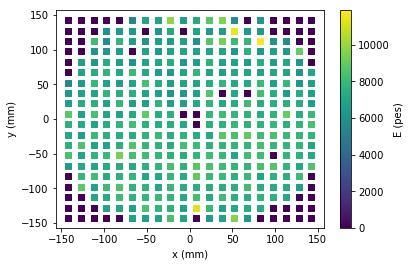

In [157]:
xrange = -150, 150
yrange = -150, 150
rrange =    20, 160
prange = - pi,  pi
Erange =  4e3, 9e3

E = fidrXR.S2e * zcorr(fidrXR.Z)

pf, _, cb = profile_and_scatter(fidrXR.X, fidrXR.Y, E, (20, 20), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")

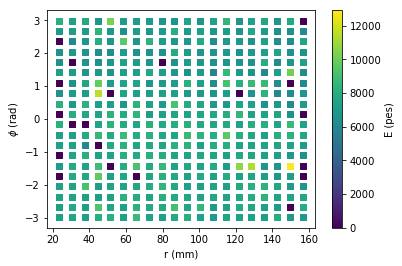

In [158]:
_, _, cb = profile_and_scatter(fidrXR.R, fidrXR.Phi, E, (20, 20), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")

In [ ]:
XRrfid1 = 10
XRxfid2 = 100
fidyXR = XR[abs(XR.Y) < XRyfid]
fidXR = fidyXR[abs(fidyXR.X) < XRxfid]
fidr1XR = fidXR[abs(fidXR.R) > XRrfid1]
fidrXR = fidr1XR[abs(fidr1XR.R) < XRxfid2]
print("Ratio:", len(fidrXR)/len(full))
print("Ratio wr 

In [ ]:


hist2d(XR.R, E, (50, 50), range=(rrange, Erange), weights=E)
x, y, _ = fitf.profileX(XR.R, E, 50, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR")

hist2d(XR.Phi, E, (50, 50), range=(prange, Erange), weights=E)
x, y, _ = fitf.profileX(XR.Phi, E, 50, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi")

def get_xycorr(xs, ys, es, eref=None):
    if eref is None:
        eref = es[es.shape[0]//2, es.shape[1]//2]
    xs   = xs.reshape(xs.size, 1)
    ys   = ys.reshape(ys.size, 1)
    print(eref)
    def xycorr(x, y):
        x_closest = np.apply_along_axis(np.argmin, 0, abs(x-xs))
        y_closest = np.apply_along_axis(np.argmin, 0, abs(y-ys))
        e = es[x_closest, y_closest]
        e[e<1e3] = eref
        return eref/ e
    return xycorr
xycorr = get_xycorr(*pf[:-1])

In [ ]:
x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 6000, 8500)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 8e3, 200))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f.values))


hist2d(shortZfid.Z, E, (50, 50), range=(zrange, Erange))
x, y, _ = fitf.profileX(shortZfid.Z, E, 30, xrange=zrange, yrange=Erange)
plt.plot(x, y, profOpt)

sel  = fitf.in_range(x, 75, 150)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.expo, x, y, (1e4, -200))
plt.plot(x, f.fn(x), fitOpt)

print(f.values)
labels("Drift time ($\mu$s)", "S2 energy (pes)")
save("S2energyCorrvsZ_fiducial")

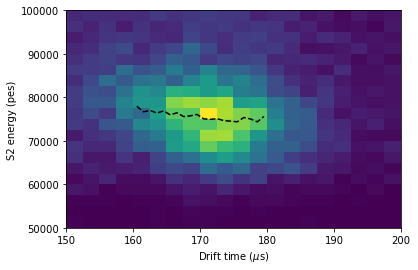

In [54]:
Erange = 50e3, 100e3
zrange = 150, 200
pErange = 60e3, 90e3
pZrange = 160, 180

hist2d(shortZ.Z, shortZ.S2e, (20, 20), range=(zrange, Erange))
x, y, _ = fitf.profileX(shortZ.Z, shortZ.S2e, 20, xrange=pZrange, yrange=pErange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 energy (pes)")
#save("S2energyvsZ")

In [69]:
minE = shortZ[shortZ.S2e > 60000]

In [70]:
rangeE = minE[minE.S2e < 90000]

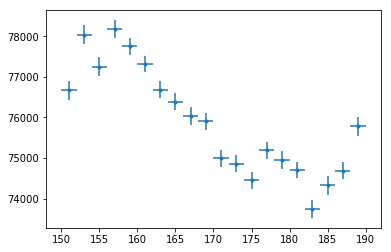

In [72]:
plot_profile_histogram(rangeE.Z.values, rangeE.S2e.values, xr = (150,190), nbins=20)

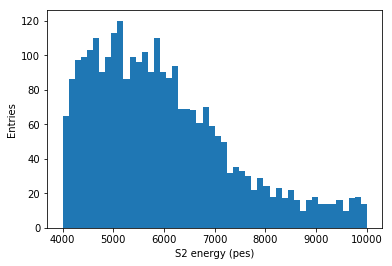

In [78]:
n, bins, patches  = hist(shortZ.S2e, 50, (4e3,10e+3))
labels("S2 energy (pes)", "Entries")

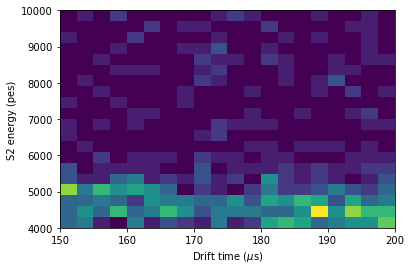

In [80]:
Erange = 4e3, 10e3
zrange = 150, 200

hist2d(shortZ.Z, shortZ.S2e, (20, 20), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy (pes)")

# S2 width

In [ ]:
zrange = 0, 200
wrange = 5, 15

hist(shortZ.S2w, 20)
labels("S2 width ($\mu$s)", "Entries")
#save("S2width")

#hist2d(shortZ.Z, shortZ.S2w*1e-3, (50, 20), range=(zrange, wrange))
#x, y, _ = fitf.profileX(shortZ.Z, shortZ.S2w*1e-3, 30, xrange=zrange, yrange=wrange)
#plt.plot(x, y, profOpt)

#labels("Drift time ($\mu$s)", "S2 energy (pes)")
#save("S2widthvsZ")

# S2 height

In [ ]:
zrange = 0, 200
hrange = 0, 40e3

hist(shortZ.S2h, 30, range=hrange)
labels("S2 height (pes)", "Entries")
#save("S2height")

#hist2d(shortZ.Z, shortZ.S2h, (50, 30), range=(zrange, hrange))
#x, y, _ = fitf.profileX(shortZ.Z, shortZ.S2h, 30, xrange=zrange, yrange=hrange)
#plt.plot(x, y, profOpt)

#labels("Drift time ($\mu$s)", "S2 height (pes)")
#save("S2heightvsZ")

# S2 peak to area ratio

In [ ]:
zrange = 0, 200
rrange = 0, 0.5

S2r = shortZ.S2h/shortZ.S2e

hist(S2r, 50, range=rrange)
labels("Height/Area", "Entries")
#save("S2Peak2Area")

#hist2d(shortZ.Z, S2r, (50, 50), range=(zrange, rrange))
#x, y, _ = fitf.profileX(shortZ.Z, S2r, 30, xrange=zrange, yrange=rrange)
#plt.plot(x, y, profOpt)

#labels("Drift time ($\mu$s)", "Height/Area")
#save("S2ratiovsZ")

# S2 vs S1

In [ ]:
Srange = 0, 20
Erange = 0, 3e5

S = shortZ.S1e
E = shortZ.S2e

hist2d(S, E, (50, 50), range=(Srange, Erange))
x, y, _ = fitf.profileX(S, E, 30, xrange=Srange, yrange=Erange)
plt.plot(x, y, profOpt)

sel = fitf.in_range(S, *Srange) & fitf.in_range(E, *Erange)
c = covariance(S[sel], E[sel])
print(*c)
labels("S1 energy (pes)", "S2 energy (pes)")
save("S2vsS1")

In [ ]:
zrange = 0, 200
Rrange = 0, 0.006

S12r = shortZ.S1e/shortZ.S2e

hist(S12r, 50, range=Rrange)
labels("S1/S2", "Entries")
save("S12ratio")

hist2d(shortZ.Z, S12r, (50, 50), range=(zrange, Rrange))
x, y, _ = fitf.profileX(shortZ.Z, S12r, 30, xrange=zrange, yrange=Rrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1/S2")
save("S12ratiovsZ")

# Temporary fiducialization

In [ ]:
shortZfid = shortZ[shortZ.R < 100]
print("Ratio:", len(shortZfid)/len(full))
print("Ratio:", len(shortZfid)/len(shortZ))
shortZfid.head()

# S2 energy fiducialized

In [ ]:
zrange = 0,200
Erange = 0e3, 200e3

hist(shortZfid.S2e, 50, range=Erange)
labels("S2 energy (pes)", "Entries")
#save("S2energy_fiducial")



In [ ]:
Erange = 50e3, 80e3
zrange = 100, 200
pErange = 55e3, 70e3
pZrange = 160, 180

hist2d(shortZ.Z/units.mus, shortZ.S2e, (20, 20), range=(zrange, Erange))
x, y, _ = fitf.profileX(shortZ.Z/units.mus, shortZ.S2e, 20, xrange=pZrange, yrange=pErange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 energy (pes)")

In [ ]:
sel  = fitf.in_range(x, 160, 180)
x, y = x[sel], y[sel]

f = fitf.fit(fitf.expo, x, y, (1e4, -200))
plt.plot(x, f.fn(x), fitOpt)
print(f.values)
labels("Drift time ($\mu$s)", "S2 energy (pes)")
#save("S2energyvsZ_fiducial")

zfun  = f.fn
zmin  = np.min(x)
zcorr = lambda z: zfun(zmin)/zfun(z)

# Correction by attachment

In [ ]:
Erange = 1e3, 200e3
E = shortZfid.S2e * zcorr(shortZfid.Z/units.mus)
y, x, _ = hist(E, 50, range=Erange)

In [ ]:
Erange = 50e3, 100e3
E = shortZfid.S2e * zcorr(shortZfid.Z/units.mus)
y, x, _ = hist(E, 25, range=Erange)

In [ ]:
x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 65e3, 75e3)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 7e4, 2000))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f.values))

labels("S2 energy (pes)", "Entries")

In [ ]:
Erange = 50e3, 100e3
E = shortZfid.S2e * zcorr(shortZfid.Z/units.mus)

y, x, _ = hist(E, 50, range=Erange)

x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 62e3, 72e3)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 7e4, 2000))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f.values))

labels("S2 energy (pes)", "Entries")



In [ ]:
Erange2 = 140e3, 170e3

# Tracking

In [ ]:
nrange = 0, 12
zrange = 0, 600

hist(shortZ.Nsipm, max(nrange), nrange)
labels("# SiPMs", "Entries")
save("Nsipm")

hist2d(shortZ.Z/units.mus, shortZ.Nsipm, (30, max(nrange)), range=(zrange, nrange))
x, y, _ = fitf.profileX(shortZ.Z, shortZ.Nsipm, 30, xrange=zrange, yrange=nrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "# SiPMs")
#save("NsipmvsZ")


# Event distribution

In [ ]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi

hist(shortZ.X, 50, range=xrange)
labels("x (mm)", "Entries")
save("X")

hist(shortZ.Y, 50, range=yrange)
labels("y (mm)", "Entries")
save("Y")

hist(shortZ.R, 50, range=rrange)
labels("r (mm)", "Entries")
save("R")

hist(shortZ.Phi, 50, range=prange)
labels("$\phi$ (rad)", "Entries")
save("Phi")

nevts, xs, ys, _ = \
hist2d(shortZ.X, shortZ.Y, (50, 50), range=(xrange, yrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)")
save("XY")

################################
hist2d(shortZ.R, shortZ.Phi, (50, 50), range=(rrange, prange))
plt.colorbar().set_label("# events")
labels("r (mm)", "$\phi$ (mm)")
save("RPhi")

# Tracking charge

In [ ]:
zrange = 0, 200
Qrange = 0, 500

hist(shortZ.S2q, 100, range=Qrange)
labels("S2 charge (pes)", "Entries")
save("S2charge")

hist2d(shortZ.Z, shortZ.S2q, (50, 100), range=(zrange, Qrange))
x, y, _ = fitf.profileX(shortZ.Z, shortZ.S2q, 30, xrange=zrange, yrange=Qrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 charge (pes)")
save("S2chargevsZ")

In [ ]:
xrange = -215, 215
yrange = -50, 50
rrange =    0, 215
prange = - pi,  pi
Qrange =    0, 500

_, _, cb = profile_and_scatter(shortZ.X, shortZ.Y, shortZ.S2q, (50, 50), xrange=xrange, yrange=yrange)
cb.set_label("Q (pes)")
labels("x (mm)", "y (mm)")
save("QvsXY")

_, _, cb = profile_and_scatter(shortZ.R, shortZ.Phi, shortZ.S2q, (50, 50), xrange=rrange, yrange=prange)
cb.set_label("Q (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("QvsRPhi")

hist2d(shortZ.R, shortZ.S2q, (50, 50), range=(rrange, Qrange))
x, y, _ = fitf.profileX(shortZ.R, shortZ.S2q, 50, xrange=rrange, yrange=Qrange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 charge (pes)")
save("QvsR")

hist2d(shortZ.Phi, shortZ.S2q, (50, 50), range=(prange, Qrange))
x, y, _ = fitf.profileX(shortZ.Phi, shortZ.S2q, 50, xrange=prange, yrange=Qrange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 charge (pes)")
save("QvsPhi")


# Energy vs position

In [ ]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi
Erange =  4e3, 9e3

E = shortZ.S2e * zcorr(shortZ.Z)

pf, _, cb = profile_and_scatter(shortZ.X, shortZ.Y, E, (50, 50), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
save("EvsXY")

_, _, cb = profile_and_scatter(shortZ.R, shortZ.Phi, E, (50, 50), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("EvsRPhi")

hist2d(shortZ.R, E, (50, 50), range=(rrange, Erange), weights=E)
x, y, _ = fitf.profileX(shortZ.R, E, 50, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR")

hist2d(shortZ.Phi, E, (50, 50), range=(prange, Erange), weights=E)
x, y, _ = fitf.profileX(shortZ.Phi, E, 50, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi")

def get_xycorr(xs, ys, es, eref=None):
    if eref is None:
        eref = es[es.shape[0]//2, es.shape[1]//2]
    xs   = xs.reshape(xs.size, 1)
    ys   = ys.reshape(ys.size, 1)
    print(eref)
    def xycorr(x, y):
        x_closest = np.apply_along_axis(np.argmin, 0, abs(x-xs))
        y_closest = np.apply_along_axis(np.argmin, 0, abs(y-ys))
        e = es[x_closest, y_closest]
        e[e<1e3] = eref
        return eref/ e
    return xycorr
xycorr = get_xycorr(*pf[:-1])


# Correction by attachment and position

In [ ]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi
Erange =  4e3, 11e3

E  = shortZ.S2e * zcorr(shortZ.Z) * xycorr(shortZ.X.values, shortZ.Y.values)

y, x, _ = hist(E, 100, Erange)

x = x[:-1] + np.diff(x) * 0.5
f = fitf.fit(fitf.gauss, x, y, (1e5, 1e4, 1e2))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f.values))

labels("E (pes)", "Entries")
save("EcorrZXY")

_, _, cb = profile_and_scatter(shortZ.X, shortZ.Y, E, (50, 50), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
save("EvsXY")

_, _, cb = profile_and_scatter(shortZ.R, shortZ.Phi, E, (50, 50), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("EvsRPhi")

hist2d(shortZ.R, E, (50, 50), range=(rrange, Erange), weights=E)
x, y, _ = fitf.profileX(shortZ.R, E, 50, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR")

hist2d(shortZ.Phi, E, (50, 50), range=(prange, Erange), weights=E)
x, y, _ = fitf.profileX(shortZ.Phi, E, 50, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi")


In [ ]:
E = shortZ.S2e * zcorr(shortZ.Z) * xycorr(shortZ.X.values, shortZ.Y.values)
T = (shortZ.time - np.min(shortZ.time))/60

Erange = 4e3, 11e3
Trange =   0, 1800

hist2d(T, E, (50, 50), range=(Trange, Erange))

x, y, _ = fitf.profileX(T, E, 50, Trange)
plt.plot(x, y, profOpt)

labels("Time (min)", "Energy (pes)")

def get_timecorr(T, E):
    eref = np.max(E)
    def timecorr(t):
        dt = np.abs(t[:, np.newaxis]-T)
        return eref / E[np.apply_along_axis(np.argmin, 1, dt)]
    return timecorr
tcorr = get_timecorr(x, y)

In [ ]:
T = (shortZ.time - np.min(shortZ.time))/60
E = shortZ.S2e * zcorr(shortZ.Z) * xycorr(shortZ.X.values, shortZ.Y.values) * tcorr(T)

Trange =   0, 1800
Erange = 4e3, 11e3

y, x, _ = hist(E, 100, Erange)

x = x[:-1] + np.diff(x) * 0.5
f = fitf.fit(fitf.gauss, x, y, (1e5, 1e4, 1e2))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f.values))

labels("E (pes)", "Entries")
save("EcorrZXYT")

hist2d(T, E, (50, 50), range=(Trange, Erange))
x, y, _ = fitf.profileX(T, E, 50, Trange)
plt.plot(x, y, profOpt)

labels("Time (min)", "Energy (pes)")
